In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
import random

In [8]:
class VoronoiTumorModel:
    def __init__(self, width=100, height=100, n_seeds=200):
        """
        Initialize the Voronoi tumor model
        
        Parameters:
        width, height: dimensions of the domain
        n_seeds: number of Voronoi seeds (cells)
        """
        self.width = width
        self.height = height
        self.n_seeds = n_seeds
        
        # Cell type definitions
        self.NECROTIC = 0      # Black
        self.QUIESCENT = 1     # Yellow
        self.PROLIFERATIVE = 2 # Red
        self.INVASIVE = 3      # Green
        self.ECM = 4           # White
        self.DEGRADED_ECM = 5  # Blue
        
        # Color mapping
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: 'yellow',
            self.PROLIFERATIVE: 'red',
            self.INVASIVE: 'green',
            self.ECM: 'white',
            self.DEGRADED_ECM: 'blue'
        }
        
        self.generate_voronoi()
        self.assign_cell_types()
    
    def generate_voronoi(self):
        """Generate Voronoi diagram with random seed points"""
        # Generate random seed points
        np.random.seed(42)  # For reproducibility
        self.points = np.random.uniform(0, min(self.width, self.height), 
                                       (self.n_seeds, 2))
        
        # Scale points to domain size
        self.points[:, 0] *= self.width / min(self.width, self.height)
        self.points[:, 1] *= self.height / min(self.width, self.height)
        
        # Create Voronoi diagram
        self.vor = Voronoi(self.points)
    
    def assign_cell_types(self):
        """Assign cell types based on spatial distribution (tumor core model)"""
        center_x, center_y = self.width/2, self.height/2
        self.cell_types = []
        
        for point in self.points:
            # Calculate distance from center
            dist = np.sqrt((point[0] - center_x)**2 + (point[1] - center_y)**2)
            max_dist = np.sqrt(center_x**2 + center_y**2)
            normalized_dist = dist / max_dist
            
            # Assign cell types based on distance from center (tumor model)
            if normalized_dist < 0.15:
                # Core: mostly necrotic
                if random.random() < 0.8:
                    cell_type = self.NECROTIC
                else:
                    cell_type = self.QUIESCENT
            elif normalized_dist < 0.35:
                # Inner region: quiescent and some proliferative
                if random.random() < 0.6:
                    cell_type = self.QUIESCENT
                elif random.random() < 0.8:
                    cell_type = self.PROLIFERATIVE
                else:
                    cell_type = self.NECROTIC
            elif normalized_dist < 0.55:
                # Active region: proliferative and invasive
                if random.random() < 0.5:
                    cell_type = self.PROLIFERATIVE
                else:
                    cell_type = self.INVASIVE
            elif normalized_dist < 0.75:
                # Invasion front: invasive and degraded ECM
                if random.random() < 0.4:
                    cell_type = self.INVASIVE
                elif random.random() < 0.7:
                    cell_type = self.DEGRADED_ECM
                else:
                    cell_type = self.ECM
            else:
                # Periphery: mostly ECM
                if random.random() < 0.8:
                    cell_type = self.ECM
                else:
                    cell_type = self.DEGRADED_ECM
            
            self.cell_types.append(cell_type)
    
    def plot_voronoi_model(self, show_grid=True, figsize=(12, 10)):
        """Plot the Voronoi tumor model"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Voronoi diagram with cell types
        ax1.set_xlim(0, self.width)
        ax1.set_ylim(0, self.height)
        ax1.set_aspect('equal')
        
        # Plot finite Voronoi regions
        for i, region in enumerate(self.vor.regions):
            if len(region) == 0 or -1 in region:
                continue
            
            # Get polygon vertices
            polygon_vertices = self.vor.vertices[region]
            
            # Check if polygon is within bounds
            if (np.all(polygon_vertices >= 0) and 
                np.all(polygon_vertices[:, 0] <= self.width) and
                np.all(polygon_vertices[:, 1] <= self.height)):
                
                # Find which seed point this region belongs to
                seed_idx = None
                for j, point_region in enumerate(self.vor.point_region):
                    if self.vor.regions[point_region] == region:
                        seed_idx = j
                        break
                
                if seed_idx is not None and seed_idx < len(self.cell_types):
                    color = self.colors[self.cell_types[seed_idx]]
                    polygon = Polygon(polygon_vertices, facecolor=color, 
                                    edgecolor='gray', alpha=0.7, linewidth=0.5)
                    ax1.add_patch(polygon)
        
        # Add grid overlay for finite difference calculation
        if show_grid:
            grid_spacing = 5
            for x in range(0, self.width + 1, grid_spacing):
                ax1.axvline(x, color='blue', alpha=0.3, linewidth=0.5)
            for y in range(0, self.height + 1, grid_spacing):
                ax1.axhline(y, color='blue', alpha=0.3, linewidth=0.5)
        
        ax1.set_title('Voronoi Tumor Model (Avascular)')
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        
        # Plot 2: Cell type distribution
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        colors_list = [self.colors[i] for i in range(6)]
        
        ax2.pie([cell_counts[i] for i in range(6)], labels=cell_names, 
                colors=colors_list, autopct='%1.1f%%')
        ax2.set_title('Cell Type Distribution')
        
        plt.tight_layout()
        return fig
    
    def get_neighbor_analysis(self):
        """Analyze neighbor relationships for CA model"""
        neighbor_data = []
        
        for i, point in enumerate(self.points):
            if i >= len(self.cell_types):
                continue
                
            # Find Voronoi neighbors
            region_idx = self.vor.point_region[i]
            region = self.vor.regions[region_idx]
            
            if len(region) == 0 or -1 in region:
                continue
            
            neighbors = []
            for ridge in self.vor.ridge_points:
                if i in ridge:
                    neighbor_idx = ridge[0] if ridge[1] == i else ridge[1]
                    if neighbor_idx < len(self.cell_types):
                        neighbors.append(neighbor_idx)
            
            neighbor_data.append({
                'cell_idx': i,
                'cell_type': self.cell_types[i],
                'position': point,
                'neighbors': neighbors,
                'neighbor_types': [self.cell_types[n] for n in neighbors if n < len(self.cell_types)]
            })
        
        return neighbor_data
    
    def export_for_simulation(self, filename='tumor_model_data.npz'):
        """Export model data for use in simulations"""
        neighbor_data = self.get_neighbor_analysis()
        
        # Prepare data for export
        positions = np.array([data['position'] for data in neighbor_data])
        cell_types = np.array([data['cell_type'] for data in neighbor_data])
        
        # Create adjacency matrix
        n_cells = len(neighbor_data)
        adjacency_matrix = np.zeros((n_cells, n_cells), dtype=bool)
        
        for i, data in enumerate(neighbor_data):
            for neighbor_idx in data['neighbors']:
                if neighbor_idx < n_cells:
                    adjacency_matrix[i, neighbor_idx] = True
        
        np.savez(filename,
                positions=positions,
                cell_types=cell_types,
                adjacency_matrix=adjacency_matrix,
                voronoi_vertices=self.vor.vertices,
                voronoi_regions=self.vor.regions)
        
        print(f"Model data exported to {filename}")
        return filename


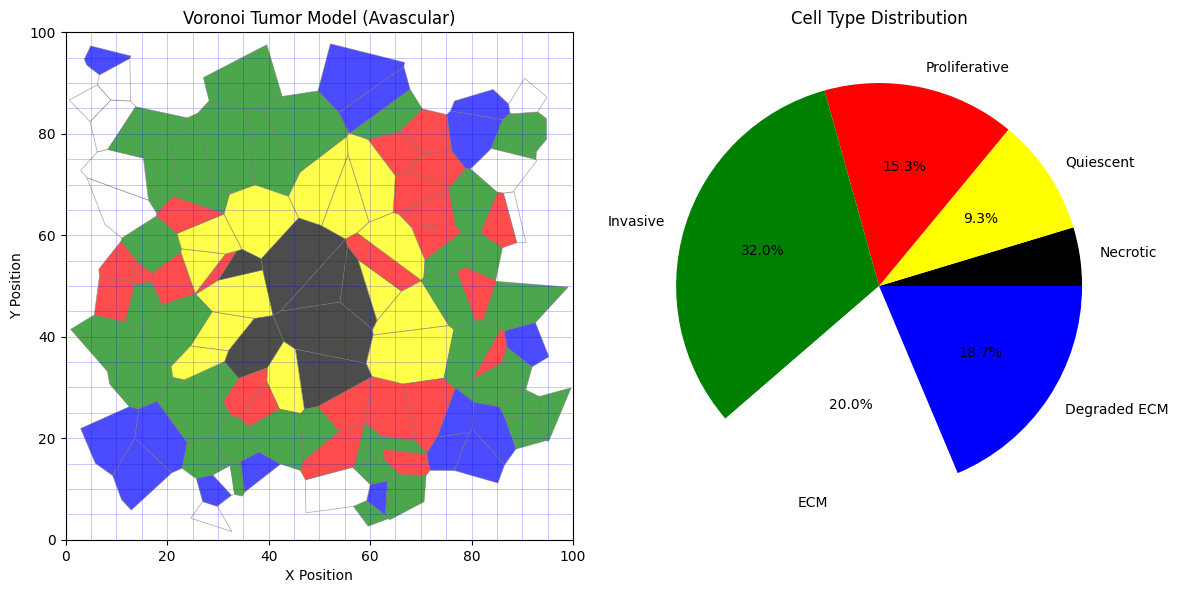

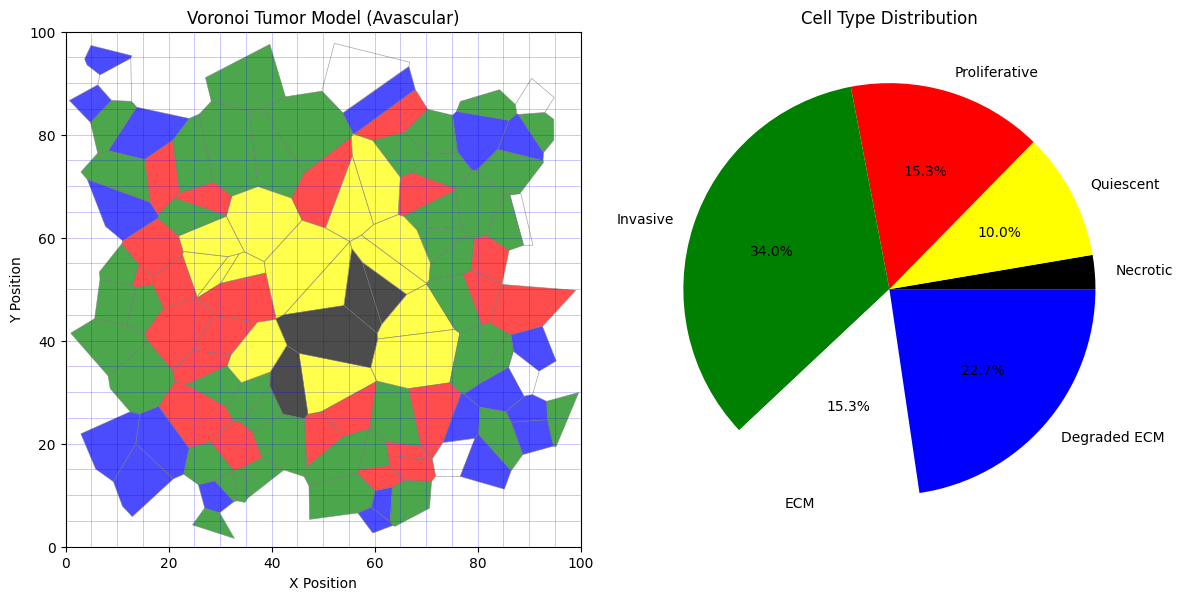


Model Statistics:
Total cells: 135
Average neighbors per cell: 5.77

Example cell (index 0):
Position: [37.45401188 95.07143064]
Type: 3 (Invasive)
Number of neighbors: 6


In [10]:
if __name__ == "__main__":
    # Create tumor model
    model = VoronoiTumorModel(width=100, height=100, n_seeds=150)
    %matplotlib inline
    # Plot the model
    fig = model.plot_voronoi_model(show_grid=True)
    plt.show()
    
    # Analyze neighbors (useful for CA rules)
    neighbor_data = model.get_neighbor_analysis()
    print(f"\nModel Statistics:")
    print(f"Total cells: {len(neighbor_data)}")
    print(f"Average neighbors per cell: {np.mean([len(d['neighbors']) for d in neighbor_data]):.2f}")
    
    # Example of accessing specific cell information
    print(f"\nExample cell (index 0):")
    if neighbor_data:
        cell = neighbor_data[0]
        print(f"Position: {cell['position']}")
        print(f"Type: {cell['cell_type']} ({['Necrotic', 'Quiescent', 'Proliferative', 'Invasive', 'ECM', 'Degraded ECM'][cell['cell_type']]})")
        print(f"Number of neighbors: {len(cell['neighbors'])}")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon, Circle
import random
from matplotlib.collections import LineCollection

In [12]:
class VoronoiTumorModel:
    def __init__(self, radius=50, n_seeds=300):
        """
        Initialize the Voronoi tumor model with circular domain
        
        Parameters:
        radius: radius of the circular domain
        n_seeds: number of Voronoi seeds (cells)
        """
        self.radius = radius
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black
        self.QUIESCENT = 1     # Yellow
        self.PROLIFERATIVE = 2 # Red
        self.INVASIVE = 3      # Green
        self.ECM = 4           # White
        self.DEGRADED_ECM = 5  # Blue
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types()
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within circular domain"""
        # Generate random seed points with higher density in tumor region
        np.random.seed(42)
        
        # Create points with varying density
        points = []
        
        # Dense points in tumor core and surrounding area
        for _ in range(int(self.n_seeds * 0.7)):
            r = np.random.exponential(scale=self.radius * 0.4)
            if r > self.radius * 0.9:
                r = self.radius * 0.9
            theta = np.random.uniform(0, 2*np.pi)
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            points.append([x, y])
        
        # Sparser points in ECM region
        for _ in range(int(self.n_seeds * 0.3)):
            r = np.random.uniform(self.radius * 0.5, self.radius * 0.95)
            theta = np.random.uniform(0, 2*np.pi)
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            points.append([x, y])
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 32, endpoint=False):
            x = self.radius * 1.2 * np.cos(theta)
            y = self.radius * 1.2 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
        
    def assign_cell_types(self):
        """Assign cell types based on spatial distribution matching the paper"""
        self.cell_types = []
        
        for point in self.points:
            # Calculate distance from center
            dist = np.sqrt(point[0]**2 + point[1]**2)
            normalized_dist = dist / self.radius
            
            # Create irregular tumor shape with some randomness
            angle = np.arctan2(point[1], point[0])
            shape_factor = 1 + 0.3 * np.sin(3 * angle) + 0.2 * np.sin(5 * angle)
            effective_dist = normalized_dist / shape_factor
            
            # Assign cell types based on distance (matching paper structure)
            rand = random.random()
            
            if effective_dist < 0.12:
                # Core: necrotic cells
                cell_type = self.NECROTIC
            elif effective_dist < 0.25:
                # Inner ring: mostly quiescent with some necrotic
                if rand < 0.7:
                    cell_type = self.QUIESCENT
                else:
                    cell_type = self.NECROTIC
            elif effective_dist < 0.4:
                # Active tumor region: proliferative cells
                if rand < 0.8:
                    cell_type = self.PROLIFERATIVE
                elif rand < 0.9:
                    cell_type = self.QUIESCENT
                else:
                    cell_type = self.INVASIVE
            elif effective_dist < 0.55:
                # Invasion zone: mix of proliferative, invasive, and degraded ECM
                if rand < 0.3:
                    cell_type = self.PROLIFERATIVE
                elif rand < 0.6:
                    cell_type = self.INVASIVE
                elif rand < 0.8:
                    cell_type = self.DEGRADED_ECM
                else:
                    cell_type = self.ECM
            elif effective_dist < 0.7:
                # Transition zone: invasive cells and degraded ECM
                if rand < 0.4:
                    cell_type = self.INVASIVE
                elif rand < 0.7:
                    cell_type = self.DEGRADED_ECM
                else:
                    cell_type = self.ECM
            else:
                # Outer region: mostly ECM with some degraded ECM
                if rand < 0.8:
                    cell_type = self.ECM
                else:
                    cell_type = self.DEGRADED_ECM
            
            self.cell_types.append(cell_type)
    
    def clip_polygon_to_circle(self, vertices):
        """Clip polygon vertices to circular boundary"""
        clipped_vertices = []
        for vertex in vertices:
            dist = np.sqrt(vertex[0]**2 + vertex[1]**2)
            if dist <= self.radius:
                clipped_vertices.append(vertex)
            else:
                # Project point onto circle boundary
                scale = self.radius / dist
                clipped_vertices.append([vertex[0] * scale, vertex[1] * scale])
        return np.array(clipped_vertices)
    
    def plot_model(self, model_type='avascular', show_grid=True, show_vessels=False, figsize=(15, 7)):
        """Plot the Voronoi tumor model matching the paper's style"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            vessel_flags = [show_vessels]
        
        for idx, (ax, title, show_vessels_flag) in enumerate(zip(axes, titles, vessel_flags)):
            # Set up the plot
            ax.set_xlim(-self.radius * 1.1, self.radius * 1.1)
            ax.set_ylim(-self.radius * 1.1, self.radius * 1.1)
            ax.set_aspect('equal')
            
            # Draw circular boundary
            circle = Circle((0, 0), self.radius, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(circle)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to circular boundary
                clipped_vertices = self.clip_polygon_to_circle(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within circle
                    cell_center = self.points[i]
                    if np.sqrt(cell_center[0]**2 + cell_center[1]**2) <= self.radius:
                        color = self.colors[self.cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = self.radius / 10
                for x in np.arange(-self.radius, self.radius + grid_spacing, grid_spacing):
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in np.arange(-self.radius, self.radius + grid_spacing, grid_spacing):
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels for vascular model"""
        # Generate random vessel network
        np.random.seed(123)
        n_vessels = 8
        
        for _ in range(n_vessels):
            # Random start point on boundary
            theta_start = np.random.uniform(0, 2*np.pi)
            start_x = self.radius * 0.9 * np.cos(theta_start)
            start_y = self.radius * 0.9 * np.sin(theta_start)
            
            # Random direction towards center with some variation
            target_angle = theta_start + np.pi + np.random.uniform(-0.5, 0.5)
            length = np.random.uniform(self.radius * 0.3, self.radius * 0.7)
            
            end_x = start_x + length * np.cos(target_angle)
            end_y = start_y + length * np.sin(target_angle)
            
            # Draw vessel as thick red line
            ax.plot([start_x, end_x], [start_y, end_y], 
                   color='red', linewidth=3, alpha=0.7)
            
            # Add small branches
            n_branches = np.random.randint(1, 4)
            for _ in range(n_branches):
                branch_start = 0.3 + 0.4 * np.random.random()
                branch_x = start_x + branch_start * (end_x - start_x)
                branch_y = start_y + branch_start * (end_y - start_y)
                
                branch_angle = target_angle + np.random.uniform(-1, 1)
                branch_length = np.random.uniform(5, 15)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='red', linewidth=2, alpha=0.7)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Tumor Model Statistics:")
        print("=" * 30)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Domain radius: {self.radius} μm")

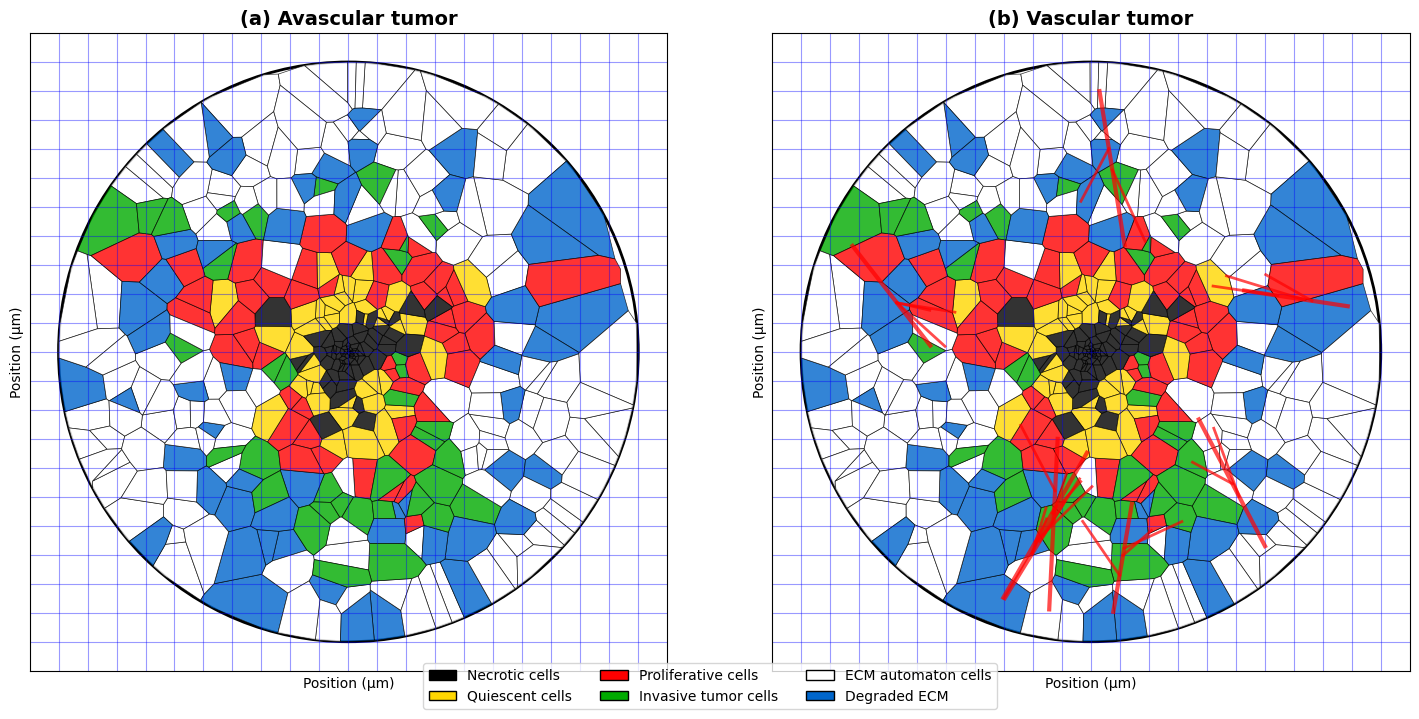

In [13]:
# Example usage
if __name__ == "__main__":
    # Create tumor model
    model = VoronoiTumorModel(radius=50, n_seeds=400)
    
    # Plot both avascular and vascular models
    fig = model.plot_model(model_type='both', show_grid=True)
    plt.show()

In [14]:
class VoronoiTumorModel:
    def __init__(self, radius=50, n_seeds=300):
        """
        Initialize the Voronoi tumor model with circular domain
        
        Parameters:
        radius: radius of the circular domain
        n_seeds: number of Voronoi seeds (cells)
        """
        self.radius = radius
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black
        self.QUIESCENT = 1     # Yellow
        self.PROLIFERATIVE = 2 # Red
        self.INVASIVE = 3      # Green
        self.ECM = 4           # White
        self.DEGRADED_ECM = 5  # Blue
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types()
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within circular domain"""
        # Generate random seed points with higher density in tumor region
        np.random.seed(42)
        
        # Create points with varying density
        points = []
        
        # Dense points in tumor core and surrounding area
        for _ in range(int(self.n_seeds * 0.7)):
            r = np.random.exponential(scale=self.radius * 0.4)
            if r > self.radius * 0.9:
                r = self.radius * 0.9
            theta = np.random.uniform(0, 2*np.pi)
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            points.append([x, y])
        
        # Sparser points in ECM region
        for _ in range(int(self.n_seeds * 0.3)):
            r = np.random.uniform(self.radius * 0.5, self.radius * 0.95)
            theta = np.random.uniform(0, 2*np.pi)
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            points.append([x, y])
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 32, endpoint=False):
            x = self.radius * 1.2 * np.cos(theta)
            y = self.radius * 1.2 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
        
    def assign_cell_types(self):
        """Assign cell types with compact clustering for visual appeal"""
        self.cell_types = []
        
        # First pass: assign base cell types by distance
        base_types = []
        for point in self.points:
            dist = np.sqrt(point[0]**2 + point[1]**2)
            normalized_dist = dist / self.radius
            
            # Create irregular tumor shape
            angle = np.arctan2(point[1], point[0])
            shape_factor = 1 + 0.3 * np.sin(3 * angle) + 0.2 * np.sin(5 * angle)
            effective_dist = normalized_dist / shape_factor
            
            # Assign base types by distance zones
            if effective_dist < 0.15:
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.28:
                base_types.append(self.QUIESCENT)
            elif effective_dist < 0.45:
                base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.65:
                if effective_dist < 0.55:
                    base_types.append(self.INVASIVE if random.random() < 0.6 else self.DEGRADED_ECM)
                else:
                    base_types.append(self.DEGRADED_ECM if random.random() < 0.7 else self.INVASIVE)
            else:
                base_types.append(self.ECM)
        
        # Second pass: create compact clusters using neighbor smoothing
        self.cell_types = base_types.copy()
        
        # Multiple smoothing iterations for compactness  
        for iteration in range(3):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                # Find nearby points for clustering
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < self.radius * 0.08) & (distances > 0))[0]
                
                if len(nearby_indices) > 0:
                    # Count cell types in neighborhood
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    # If there's a dominant type in neighborhood, consider switching
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        # Strong clustering tendency - switch if many neighbors are same type
                        if dominant_count >= len(nearby_indices) * 0.6:
                            # Only switch to compatible types (maintain general zones)
                            current_zone = self.get_cell_zone(point)
                            if self.is_compatible_type(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Third pass: add some strategic isolated clusters for visual interest
        self.add_strategic_clusters()
    
    def get_cell_zone(self, point):
        """Determine which zone a point is in"""
        dist = np.sqrt(point[0]**2 + point[1]**2)
        normalized_dist = dist / self.radius
        
        if normalized_dist < 0.2:
            return 'core'
        elif normalized_dist < 0.35:
            return 'inner'
        elif normalized_dist < 0.55:
            return 'active'
        elif normalized_dist < 0.75:
            return 'invasion'
        else:
            return 'ecm'
    
    def is_compatible_type(self, cell_type, zone):
        """Check if cell type is compatible with zone"""
        compatible = {
            'core': [self.NECROTIC, self.QUIESCENT],
            'inner': [self.NECROTIC, self.QUIESCENT, self.PROLIFERATIVE],
            'active': [self.QUIESCENT, self.PROLIFERATIVE, self.INVASIVE],
            'invasion': [self.PROLIFERATIVE, self.INVASIVE, self.DEGRADED_ECM],
            'ecm': [self.INVASIVE, self.DEGRADED_ECM, self.ECM]
        }
        return cell_type in compatible.get(zone, [])
    
    def add_strategic_clusters(self):
        """Add some strategic isolated clusters for visual appeal"""
        # Add some invasive cell clusters in ECM region
        ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.ECM]
        
        # Create a few invasive clusters
        for _ in range(3):
            if ecm_indices:
                center_idx = random.choice(ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby ECM cells to convert to invasive
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                nearby_ecm = [i for i in ecm_indices if distances[i] < self.radius * 0.06]
                
                # Convert some to invasive cells
                for idx in nearby_ecm[:random.randint(2, 5)]:
                    if random.random() < 0.7:
                        self.cell_types[idx] = self.INVASIVE
    
    def clip_polygon_to_circle(self, vertices):
        """Clip polygon vertices to circular boundary"""
        clipped_vertices = []
        for vertex in vertices:
            dist = np.sqrt(vertex[0]**2 + vertex[1]**2)
            if dist <= self.radius:
                clipped_vertices.append(vertex)
            else:
                # Project point onto circle boundary
                scale = self.radius / dist
                clipped_vertices.append([vertex[0] * scale, vertex[1] * scale])
        return np.array(clipped_vertices)
    
    def plot_model(self, model_type='avascular', show_grid=True, show_vessels=False, figsize=(15, 7)):
        """Plot the Voronoi tumor model matching the paper's style"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            vessel_flags = [show_vessels]
        
        for idx, (ax, title, show_vessels_flag) in enumerate(zip(axes, titles, vessel_flags)):
            # Set up the plot
            ax.set_xlim(-self.radius * 1.1, self.radius * 1.1)
            ax.set_ylim(-self.radius * 1.1, self.radius * 1.1)
            ax.set_aspect('equal')
            
            # Draw circular boundary
            circle = Circle((0, 0), self.radius, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(circle)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to circular boundary
                clipped_vertices = self.clip_polygon_to_circle(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within circle
                    cell_center = self.points[i]
                    if np.sqrt(cell_center[0]**2 + cell_center[1]**2) <= self.radius:
                        color = self.colors[self.cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = self.radius / 10
                for x in np.arange(-self.radius, self.radius + grid_spacing, grid_spacing):
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in np.arange(-self.radius, self.radius + grid_spacing, grid_spacing):
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels for vascular model"""
        # Generate random vessel network
        np.random.seed(123)
        n_vessels = 8
        
        for _ in range(n_vessels):
            # Random start point on boundary
            theta_start = np.random.uniform(0, 2*np.pi)
            start_x = self.radius * 0.9 * np.cos(theta_start)
            start_y = self.radius * 0.9 * np.sin(theta_start)
            
            # Random direction towards center with some variation
            target_angle = theta_start + np.pi + np.random.uniform(-0.5, 0.5)
            length = np.random.uniform(self.radius * 0.3, self.radius * 0.7)
            
            end_x = start_x + length * np.cos(target_angle)
            end_y = start_y + length * np.sin(target_angle)
            
            # Draw vessel as thick red line
            ax.plot([start_x, end_x], [start_y, end_y], 
                   color='red', linewidth=3, alpha=0.7)
            
            # Add small branches
            n_branches = np.random.randint(1, 4)
            for _ in range(n_branches):
                branch_start = 0.3 + 0.4 * np.random.random()
                branch_x = start_x + branch_start * (end_x - start_x)
                branch_y = start_y + branch_start * (end_y - start_y)
                
                branch_angle = target_angle + np.random.uniform(-1, 1)
                branch_length = np.random.uniform(5, 15)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='red', linewidth=2, alpha=0.7)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Tumor Model Statistics:")
        print("=" * 30)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Domain radius: {self.radius} μm")

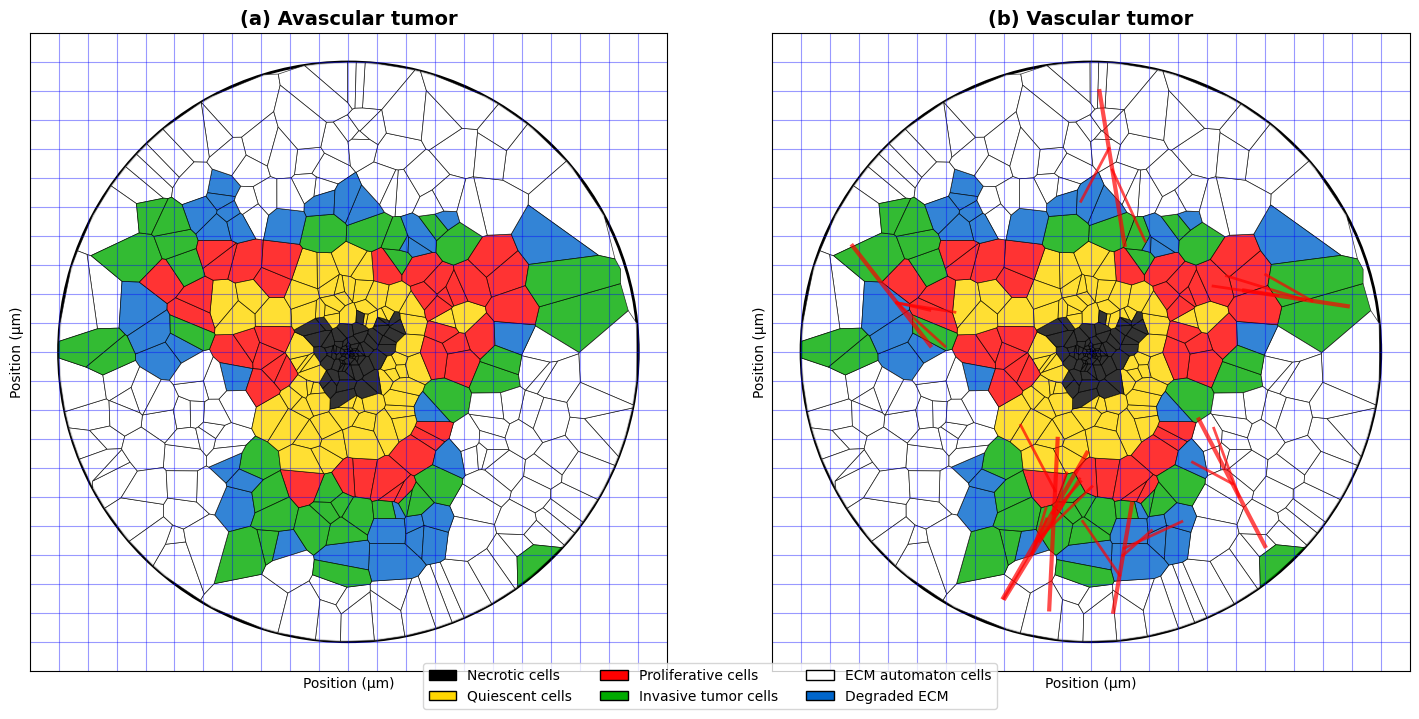

In [15]:
if __name__ == "__main__":
    # Create tumor model
    model = VoronoiTumorModel(radius=50, n_seeds=400)
    
    # Plot both avascular and vascular models
    fig = model.plot_model(model_type='both', show_grid=True)
    plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon, Ellipse
import random
from matplotlib.collections import LineCollection

In [20]:
class VoronoiTumorModel:
    def __init__(self, a=60, b=45, n_seeds=350):
        """
        Initialize the Voronoi tumor model with oval domain
        
        Parameters:
        a, b: semi-major and semi-minor axes of the ellipse
        n_seeds: number of Voronoi seeds (cells)
        """
        self.a = a  # semi-major axis
        self.b = b  # semi-minor axis
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black - core
        self.QUIESCENT = 1     # Yellow - around core
        self.PROLIFERATIVE = 2 # Red - active region
        self.INVASIVE = 3      # Green - scattered in degraded ECM
        self.ECM = 4           # White - outer region
        self.DEGRADED_ECM = 5  # Blue - invasion zone
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types_avascular()
    
    def is_inside_ellipse(self, x, y, scale=1.0):
        """Check if point is inside ellipse"""
        return (x**2 / (self.a * scale)**2) + (y**2 / (self.b * scale)**2) <= 1
    
    def ellipse_distance(self, x, y):
        """Calculate normalized distance from ellipse center (0 at center, 1 at boundary)"""
        return np.sqrt((x**2 / self.a**2) + (y**2 / self.b**2))
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within oval domain"""
        np.random.seed(42)
        
        points = []
        
        # Generate points with higher density in tumor core
        for _ in range(self.n_seeds):
            # Use rejection sampling to generate points in ellipse
            attempts = 0
            while attempts < 100:
                # Generate in bounding rectangle
                x = np.random.uniform(-self.a * 0.95, self.a * 0.95)
                y = np.random.uniform(-self.b * 0.95, self.b * 0.95)
                
                if self.is_inside_ellipse(x, y, scale=0.95):
                    points.append([x, y])
                    break
                attempts += 1
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 40, endpoint=False):
            x = self.a * 1.3 * np.cos(theta)
            y = self.b * 1.3 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
    
    def assign_cell_types_avascular(self):
        """Assign cell types for avascular model with proper layered structure"""
        self.cell_types = []
        
        # First pass: assign base cell types by elliptical distance
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Create slight irregularity in boundaries
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.15 * np.sin(4 * angle) + 0.1 * np.sin(7 * angle)
            effective_dist = norm_dist * irregularity
            
            # Layered structure: core → quiescent → proliferative → degraded ECM + invasive → ECM
            if effective_dist < 0.2:
                # Necrotic core
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.4:
                # Quiescent layer around core
                base_types.append(self.QUIESCENT)
            elif effective_dist < 0.65:
                # Proliferative layer
                base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.85:
                # Degraded ECM zone with some invasive cells
                if random.random() < 0.75:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # Outer ECM
                base_types.append(self.ECM)
        
        # Second pass: create compact clusters while maintaining layered structure
        self.cell_types = base_types.copy()
        
        # Multiple smoothing iterations for compactness
        for iteration in range(4):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                # Find nearby points for clustering
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < max(self.a, self.b) * 0.08) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:
                    # Count cell types in neighborhood
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    # Find dominant type
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        # Strong clustering - switch if majority neighbors are same type
                        if dominant_count >= len(nearby_indices) * 0.6:
                            # Only switch to compatible types within same general zone
                            current_zone = self.get_cell_zone_oval(point)
                            if self.is_compatible_type_oval(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Third pass: add strategic invasive cell clusters in degraded ECM
        self.add_invasive_clusters_in_degraded_ecm()
    
    def assign_cell_types_vascular(self):
        """Assign cell types for vascular model - slightly different distribution"""
        self.cell_types = []
        
        # Vascular tumors have different morphology due to blood supply
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Less regular boundaries due to vascular supply
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.25 * np.sin(3 * angle) + 0.15 * np.sin(6 * angle)
            effective_dist = norm_dist * irregularity
            
            # Vascular model: smaller necrotic core, more proliferative cells
            if effective_dist < 0.15:
                # Smaller necrotic core due to better oxygenation
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.35:
                # Mixed quiescent and some proliferative
                if random.random() < 0.7:
                    base_types.append(self.QUIESCENT)
                else:
                    base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.7:
                # Larger proliferative zone due to vascular supply
                if random.random() < 0.8:
                    base_types.append(self.PROLIFERATIVE)
                else:
                    base_types.append(self.QUIESCENT)
            elif effective_dist < 0.85:
                # Degraded ECM with more invasive cells
                if random.random() < 0.6:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # ECM region
                base_types.append(self.ECM)
        
        # Apply same clustering logic
        self.cell_types = base_types.copy()
        
        # Clustering iterations
        for iteration in range(4):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < max(self.a, self.b) * 0.08) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        if dominant_count >= len(nearby_indices) * 0.6:
                            current_zone = self.get_cell_zone_oval(point)
                            if self.is_compatible_type_oval(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Add invasive clusters
        self.add_invasive_clusters_in_degraded_ecm()
    
    def get_cell_zone_oval(self, point):
        """Determine which zone a point is in (oval version)"""
        norm_dist = self.ellipse_distance(point[0], point[1])
        
        if norm_dist < 0.25:
            return 'core'
        elif norm_dist < 0.45:
            return 'quiescent'
        elif norm_dist < 0.7:
            return 'proliferative'
        elif norm_dist < 0.9:
            return 'invasion'
        else:
            return 'ecm'
    
    def is_compatible_type_oval(self, cell_type, zone):
        """Check if cell type is compatible with oval zone"""
        compatible = {
            'core': [self.NECROTIC, self.QUIESCENT],
            'quiescent': [self.NECROTIC, self.QUIESCENT, self.PROLIFERATIVE],
            'proliferative': [self.QUIESCENT, self.PROLIFERATIVE, self.INVASIVE],
            'invasion': [self.PROLIFERATIVE, self.INVASIVE, self.DEGRADED_ECM],
            'ecm': [self.DEGRADED_ECM, self.ECM, self.INVASIVE]
        }
        return cell_type in compatible.get(zone, [])
    
    def add_invasive_clusters_in_degraded_ecm(self):
        """Add invasive cell clusters within degraded ECM regions"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create several invasive clusters within degraded ECM
        for _ in range(4):
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.06
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert some to invasive cells (green clusters in blue regions)
                for idx in nearby_degraded[:random.randint(3, 6)]:
                    if random.random() < 0.8:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def clip_polygon_to_ellipse(self, vertices):
        """Clip polygon vertices to elliptical boundary"""
        clipped_vertices = []
        for vertex in vertices:
            if self.is_inside_ellipse(vertex[0], vertex[1]):
                clipped_vertices.append(vertex)
            else:
                # Project point onto ellipse boundary
                # Find closest point on ellipse
                x, y = vertex[0], vertex[1]
                # Simple approximation - scale to ellipse boundary
                norm_dist = self.ellipse_distance(x, y)
                if norm_dist > 0:
                    scale = 1.0 / norm_dist
                    clipped_vertices.append([x * scale, y * scale])
                else:
                    clipped_vertices.append(vertex)
        return np.array(clipped_vertices) if clipped_vertices else vertices
    
    def plot_model(self, model_type='both', show_grid=True, figsize=(16, 8)):
        """Plot the Voronoi tumor model matching the paper's oval structure"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            
            # Generate different cell distributions for each model
            self.assign_cell_types_avascular()
            avascular_types = self.cell_types.copy()
            
            self.assign_cell_types_vascular()
            vascular_types = self.cell_types.copy()
            
            cell_type_sets = [avascular_types, vascular_types]
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            
            if model_type == 'vascular':
                self.assign_cell_types_vascular()
            else:
                self.assign_cell_types_avascular()
            
            cell_type_sets = [self.cell_types]
            vessel_flags = [model_type == 'vascular']
        
        for idx, (ax, title, current_cell_types, show_vessels_flag) in enumerate(zip(axes, titles, cell_type_sets, vessel_flags)):
            # Set up the plot
            plot_margin = max(self.a, self.b) * 1.4
            ax.set_xlim(-plot_margin, plot_margin)
            ax.set_ylim(-plot_margin, plot_margin)
            ax.set_aspect('equal')
            
            # Draw elliptical boundary
            ellipse = Ellipse((0, 0), 2*self.a, 2*self.b, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(ellipse)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to elliptical boundary
                clipped_vertices = self.clip_polygon_to_ellipse(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within ellipse
                    cell_center = self.points[i]
                    if self.is_inside_ellipse(cell_center[0], cell_center[1]):
                        color = self.colors[current_cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = max(self.a, self.b) / 8
                x_range = np.arange(-self.a, self.a + grid_spacing, grid_spacing)
                y_range = np.arange(-self.b, self.b + grid_spacing, grid_spacing)
                
                for x in x_range:
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in y_range:
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model (outside the ellipse)
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels floating outside the oval domain"""
        np.random.seed(123)
        n_vessels = 14
        
        for _ in range(n_vessels):
            # Random position on the ellipse boundary
            theta = np.random.uniform(0, 2*np.pi)
            boundary_x = self.a * np.cos(theta)
            boundary_y = self.b * np.sin(theta)
            
            # Vessel extends outward from boundary
            vessel_length = np.random.uniform(max(self.a, self.b) * 0.4, max(self.a, self.b) * 0.8)
            
            # Direction: outward normal to ellipse + some randomness
            # Normal to ellipse at point (a*cos(t), b*sin(t)) is (cos(t)/a, sin(t)/b)
            normal_x = np.cos(theta) / self.a
            normal_y = np.sin(theta) / self.b
            # Normalize the normal vector
            normal_length = np.sqrt(normal_x**2 + normal_y**2)
            normal_x /= normal_length
            normal_y /= normal_length
            
            # Add some randomness to the direction
            random_angle = np.random.uniform(-0.3, 0.3)
            cos_r, sin_r = np.cos(random_angle), np.sin(random_angle)
            dir_x = normal_x * cos_r - normal_y * sin_r
            dir_y = normal_x * sin_r + normal_y * cos_r
            
            # Main vessel trunk extending outward
            trunk_end_x = boundary_x + vessel_length * dir_x
            trunk_end_y = boundary_y + vessel_length * dir_y
            
            # Draw main vessel trunk
            ax.plot([boundary_x, trunk_end_x], [boundary_y, trunk_end_y], 
                   color='#CC0000', linewidth=4, alpha=0.8, solid_capstyle='round')
            
            # Add branching vessels
            n_branches = np.random.randint(2, 5)
            for i in range(n_branches):
                # Branch point along the trunk
                branch_ratio = 0.3 + (0.5 * i / n_branches) + np.random.uniform(-0.1, 0.1)
                branch_x = boundary_x + branch_ratio * (trunk_end_x - boundary_x)
                branch_y = boundary_y + branch_ratio * (trunk_end_y - boundary_y)
                
                # Branch direction
                branch_angle = np.arctan2(dir_y, dir_x) + np.random.uniform(-0.7, 0.7)
                branch_length = np.random.uniform(max(self.a, self.b) * 0.15, max(self.a, self.b) * 0.3)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                # Draw branch
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='#CC0000', linewidth=2.5, alpha=0.8, solid_capstyle='round')
            
            # Add vessel endpoint
            ax.scatter(trunk_end_x, trunk_end_y, c='#AA0000', s=25, alpha=0.8, zorder=5)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Oval Tumor Model Statistics:")
        print("=" * 35)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Ellipse dimensions: {2*self.a} × {2*self.b} μm")

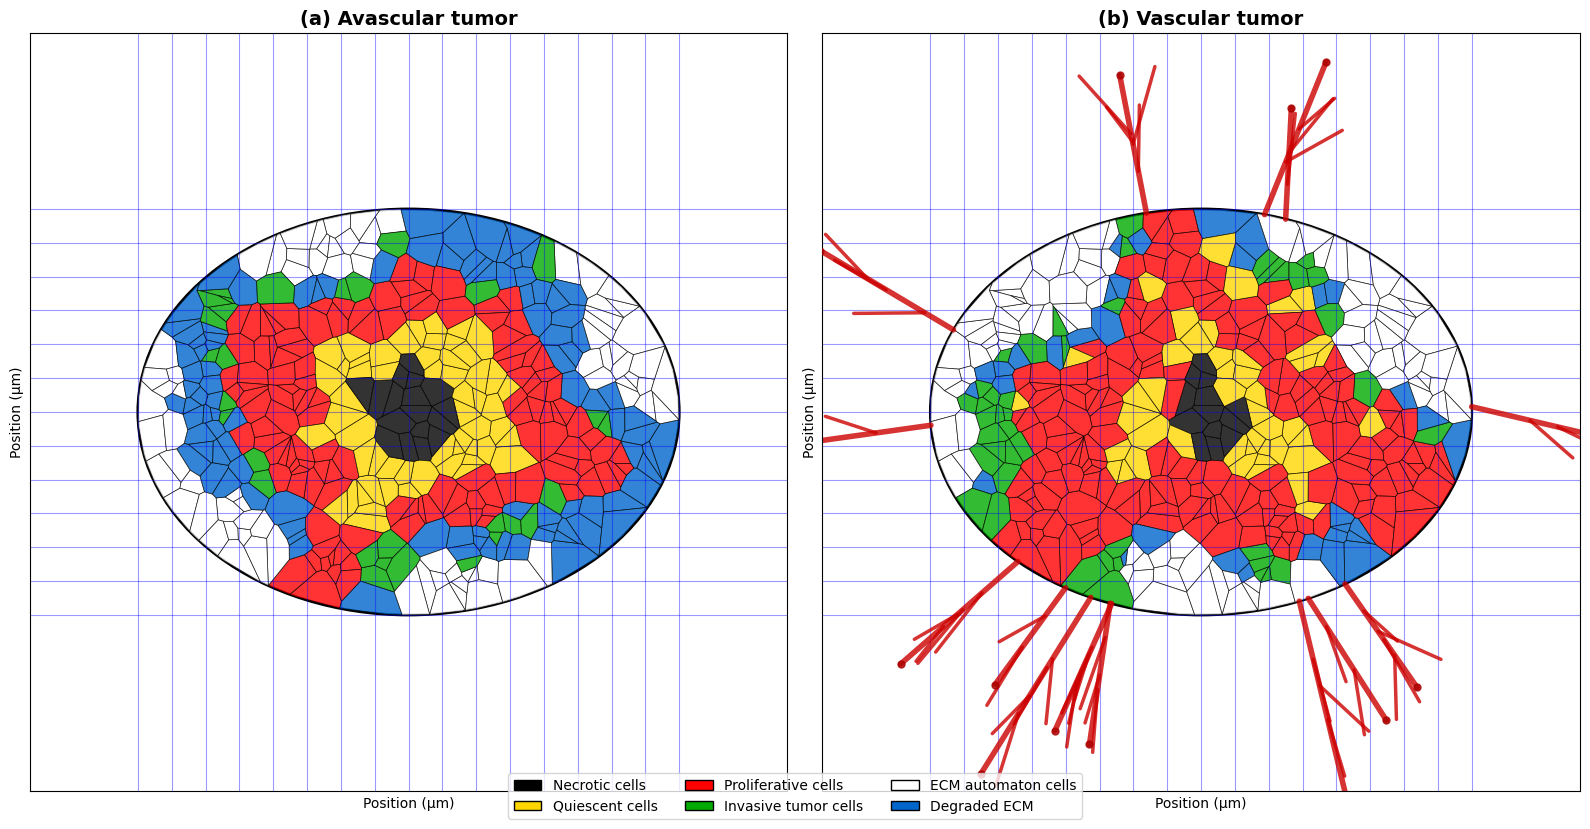

In [21]:
if __name__ == "__main__":
    # Create oval tumor model
    model = VoronoiTumorModel(a=60, b=45, n_seeds=400)
    
    # Plot both avascular and vascular models
    fig = model.plot_model(model_type='both', show_grid=True)
    plt.show()

In [22]:
class VoronoiTumorModel:
    def __init__(self, a=45, b=60, n_seeds=350):
        """
        Initialize the Voronoi tumor model with oval domain
        
        Parameters:
        a: semi-minor axis (x-axis) - now smaller
        b: semi-major axis (y-axis) - now larger  
        n_seeds: number of Voronoi seeds (cells)
        """
        self.a = a  # semi-minor axis (x-direction)
        self.b = b  # semi-major axis (y-direction) 
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black - core
        self.QUIESCENT = 1     # Yellow - around core
        self.PROLIFERATIVE = 2 # Red - active region
        self.INVASIVE = 3      # Green - scattered in degraded ECM
        self.ECM = 4           # White - outer region
        self.DEGRADED_ECM = 5  # Blue - invasion zone
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types_avascular()
    
    def is_inside_ellipse(self, x, y, scale=1.0):
        """Check if point is inside ellipse"""
        return (x**2 / (self.a * scale)**2) + (y**2 / (self.b * scale)**2) <= 1
    
    def ellipse_distance(self, x, y):
        """Calculate normalized distance from ellipse center (0 at center, 1 at boundary)"""
        return np.sqrt((x**2 / self.a**2) + (y**2 / self.b**2))
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within oval domain"""
        np.random.seed(42)
        
        points = []
        
        # Generate points with higher density in tumor core
        for _ in range(self.n_seeds):
            # Use rejection sampling to generate points in ellipse
            attempts = 0
            while attempts < 100:
                # Generate in bounding rectangle
                x = np.random.uniform(-self.a * 0.95, self.a * 0.95)
                y = np.random.uniform(-self.b * 0.95, self.b * 0.95)
                
                if self.is_inside_ellipse(x, y, scale=0.95):
                    points.append([x, y])
                    break
                attempts += 1
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 40, endpoint=False):
            x = self.a * 1.3 * np.cos(theta)
            y = self.b * 1.3 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
    
    def assign_cell_types_avascular(self):
        """Assign cell types for avascular model with more compact tumor (more ECM)"""
        self.cell_types = []
        
        # First pass: assign base cell types by elliptical distance
        # Make tumor more compact by reducing the active tumor region
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Create slight irregularity in boundaries
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.15 * np.sin(4 * angle) + 0.1 * np.sin(7 * angle)
            effective_dist = norm_dist * irregularity
            
            # More compact layered structure: smaller tumor core, more ECM
            if effective_dist < 0.15:  # Smaller necrotic core
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.28:  # Smaller quiescent layer
                base_types.append(self.QUIESCENT)
            elif effective_dist < 0.45:  # Smaller proliferative layer
                base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.65:  # Smaller invasion zone
                if random.random() < 0.7:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # Much larger ECM region for compact representation
                base_types.append(self.ECM)
        
        # Second pass: create compact clusters while maintaining layered structure
        self.cell_types = base_types.copy()
        
        # Multiple smoothing iterations for compactness
        for iteration in range(4):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                # Find nearby points for clustering
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < max(self.a, self.b) * 0.08) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:
                    # Count cell types in neighborhood
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    # Find dominant type
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        # Strong clustering - switch if majority neighbors are same type
                        if dominant_count >= len(nearby_indices) * 0.6:
                            # Only switch to compatible types within same general zone
                            current_zone = self.get_cell_zone_oval(point)
                            if self.is_compatible_type_oval(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Third pass: add strategic invasive cell clusters in degraded ECM
        self.add_invasive_clusters_in_degraded_ecm()
    
    def assign_cell_types_vascular(self):
        """Assign cell types for vascular model with more compact tumor"""
        self.cell_types = []
        
        # Vascular tumors have different morphology due to blood supply
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Less regular boundaries due to vascular supply
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.25 * np.sin(3 * angle) + 0.15 * np.sin(6 * angle)
            effective_dist = norm_dist * irregularity
            
            # Vascular model: smaller necrotic core, more proliferative cells, but still compact
            if effective_dist < 0.12:  # Smaller necrotic core due to better oxygenation
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.25:  # Mixed quiescent and some proliferative
                if random.random() < 0.7:
                    base_types.append(self.QUIESCENT)
                else:
                    base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.5:  # Larger proliferative zone due to vascular supply
                if random.random() < 0.8:
                    base_types.append(self.PROLIFERATIVE)
                else:
                    base_types.append(self.QUIESCENT)
            elif effective_dist < 0.7:  # Degraded ECM with more invasive cells
                if random.random() < 0.6:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # Large ECM region for compact representation
                base_types.append(self.ECM)
        
        # Apply same clustering logic
        self.cell_types = base_types.copy()
        
        # Clustering iterations
        for iteration in range(4):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < max(self.a, self.b) * 0.08) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        if dominant_count >= len(nearby_indices) * 0.6:
                            current_zone = self.get_cell_zone_oval(point)
                            if self.is_compatible_type_oval(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Add invasive clusters
        self.add_invasive_clusters_in_degraded_ecm()
    
    def get_cell_zone_oval(self, point):
        """Determine which zone a point is in (oval version) - updated for compact structure"""
        norm_dist = self.ellipse_distance(point[0], point[1])
        
        if norm_dist < 0.2:
            return 'core'
        elif norm_dist < 0.35:
            return 'quiescent'
        elif norm_dist < 0.55:
            return 'proliferative'
        elif norm_dist < 0.75:
            return 'invasion'
        else:
            return 'ecm'
    
    def is_compatible_type_oval(self, cell_type, zone):
        """Check if cell type is compatible with oval zone"""
        compatible = {
            'core': [self.NECROTIC, self.QUIESCENT],
            'quiescent': [self.NECROTIC, self.QUIESCENT, self.PROLIFERATIVE],
            'proliferative': [self.QUIESCENT, self.PROLIFERATIVE, self.INVASIVE],
            'invasion': [self.PROLIFERATIVE, self.INVASIVE, self.DEGRADED_ECM],
            'ecm': [self.DEGRADED_ECM, self.ECM, self.INVASIVE]
        }
        return cell_type in compatible.get(zone, [])
    
    def add_invasive_clusters_in_degraded_ecm(self):
        """Add invasive cell clusters within degraded ECM regions"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create several invasive clusters within degraded ECM
        for _ in range(3):  # Slightly fewer clusters for more compact representation
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.06
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert some to invasive cells (green clusters in blue regions)
                for idx in nearby_degraded[:random.randint(2, 4)]:  # Smaller clusters
                    if random.random() < 0.8:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def clip_polygon_to_ellipse(self, vertices):
        """Clip polygon vertices to elliptical boundary"""
        clipped_vertices = []
        for vertex in vertices:
            if self.is_inside_ellipse(vertex[0], vertex[1]):
                clipped_vertices.append(vertex)
            else:
                # Project point onto ellipse boundary
                # Find closest point on ellipse
                x, y = vertex[0], vertex[1]
                # Simple approximation - scale to ellipse boundary
                norm_dist = self.ellipse_distance(x, y)
                if norm_dist > 0:
                    scale = 1.0 / norm_dist
                    clipped_vertices.append([x * scale, y * scale])
                else:
                    clipped_vertices.append(vertex)
        return np.array(clipped_vertices) if clipped_vertices else vertices
    
    def plot_model(self, model_type='both', show_grid=True, figsize=(16, 8)):
        """Plot the Voronoi tumor model matching the paper's oval structure"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            
            # Generate different cell distributions for each model
            self.assign_cell_types_avascular()
            avascular_types = self.cell_types.copy()
            
            self.assign_cell_types_vascular()
            vascular_types = self.cell_types.copy()
            
            cell_type_sets = [avascular_types, vascular_types]
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            
            if model_type == 'vascular':
                self.assign_cell_types_vascular()
            else:
                self.assign_cell_types_avascular()
            
            cell_type_sets = [self.cell_types]
            vessel_flags = [model_type == 'vascular']
        
        for idx, (ax, title, current_cell_types, show_vessels_flag) in enumerate(zip(axes, titles, cell_type_sets, vessel_flags)):
            # Set up the plot - note: b is now the larger dimension (y-axis)
            plot_margin = max(self.a, self.b) * 1.4
            ax.set_xlim(-plot_margin, plot_margin)
            ax.set_ylim(-plot_margin, plot_margin)
            ax.set_aspect('equal')
            
            # Draw elliptical boundary - now taller than wide
            ellipse = Ellipse((0, 0), 2*self.a, 2*self.b, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(ellipse)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to elliptical boundary
                clipped_vertices = self.clip_polygon_to_ellipse(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within ellipse
                    cell_center = self.points[i]
                    if self.is_inside_ellipse(cell_center[0], cell_center[1]):
                        color = self.colors[current_cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = max(self.a, self.b) / 8
                x_range = np.arange(-self.a, self.a + grid_spacing, grid_spacing)
                y_range = np.arange(-self.b, self.b + grid_spacing, grid_spacing)
                
                for x in x_range:
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in y_range:
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model (outside the ellipse)
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels floating outside the oval domain"""
        np.random.seed(123)
        n_vessels = 14
        
        for _ in range(n_vessels):
            # Random position on the ellipse boundary
            theta = np.random.uniform(0, 2*np.pi)
            boundary_x = self.a * np.cos(theta)
            boundary_y = self.b * np.sin(theta)
            
            # Vessel extends outward from boundary
            vessel_length = np.random.uniform(max(self.a, self.b) * 0.4, max(self.a, self.b) * 0.8)
            
            # Direction: outward normal to ellipse + some randomness
            # Normal to ellipse at point (a*cos(t), b*sin(t)) is (cos(t)/a, sin(t)/b)
            normal_x = np.cos(theta) / self.a
            normal_y = np.sin(theta) / self.b
            # Normalize the normal vector
            normal_length = np.sqrt(normal_x**2 + normal_y**2)
            normal_x /= normal_length
            normal_y /= normal_length
            
            # Add some randomness to the direction
            random_angle = np.random.uniform(-0.3, 0.3)
            cos_r, sin_r = np.cos(random_angle), np.sin(random_angle)
            dir_x = normal_x * cos_r - normal_y * sin_r
            dir_y = normal_x * sin_r + normal_y * cos_r
            
            # Main vessel trunk extending outward
            trunk_end_x = boundary_x + vessel_length * dir_x
            trunk_end_y = boundary_y + vessel_length * dir_y
            
            # Draw main vessel trunk
            ax.plot([boundary_x, trunk_end_x], [boundary_y, trunk_end_y], 
                   color='#CC0000', linewidth=4, alpha=0.8, solid_capstyle='round')
            
            # Add branching vessels
            n_branches = np.random.randint(2, 5)
            for i in range(n_branches):
                # Branch point along the trunk
                branch_ratio = 0.3 + (0.5 * i / n_branches) + np.random.uniform(-0.1, 0.1)
                branch_x = boundary_x + branch_ratio * (trunk_end_x - boundary_x)
                branch_y = boundary_y + branch_ratio * (trunk_end_y - boundary_y)
                
                # Branch direction
                branch_angle = np.arctan2(dir_y, dir_x) + np.random.uniform(-0.7, 0.7)
                branch_length = np.random.uniform(max(self.a, self.b) * 0.15, max(self.a, self.b) * 0.3)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                # Draw branch
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='#CC0000', linewidth=2.5, alpha=0.8, solid_capstyle='round')
            
            # Add vessel endpoint
            ax.scatter(trunk_end_x, trunk_end_y, c='#AA0000', s=25, alpha=0.8, zorder=5)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Oval Tumor Model Statistics:")
        print("=" * 35)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Ellipse dimensions: {2*self.a} × {2*self.b} μm (width × height)")

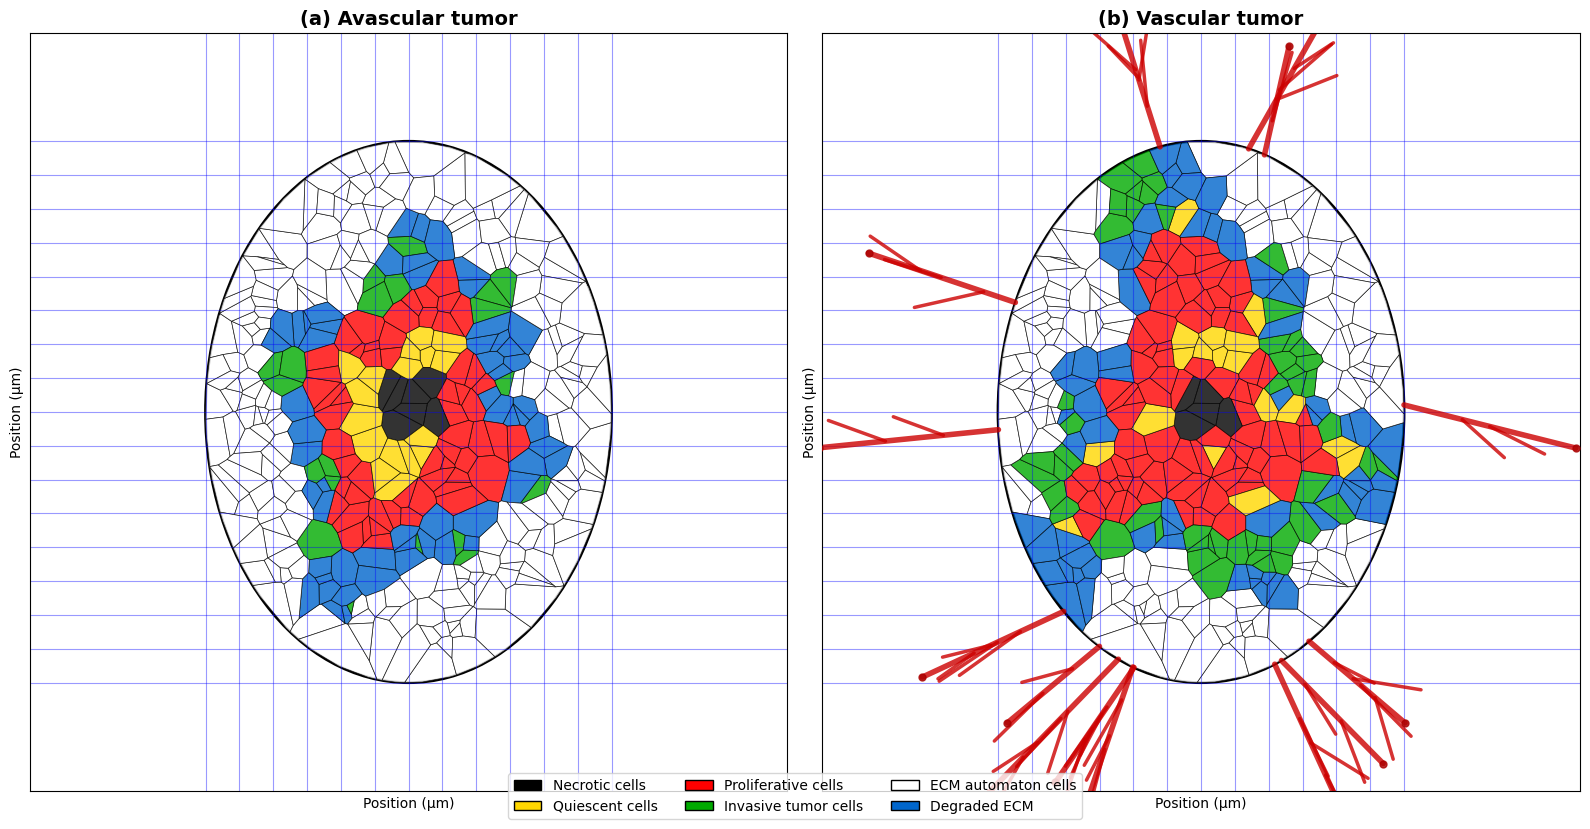

In [23]:
if __name__ == "__main__":
    # Create model instance with corrected orientation
    model = VoronoiTumorModel(a=45, b=60, n_seeds=350)  # a=width, b=height
    
    # Plot both models
    fig = model.plot_model(model_type='both')
    plt.show()

In [24]:
class VoronoiTumorModel:
    def __init__(self, a=45, b=60, n_seeds=350):
        """
        Initialize the Voronoi tumor model with oval domain
        
        Parameters:
        a: semi-minor axis (x-axis) - now smaller
        b: semi-major axis (y-axis) - now larger  
        n_seeds: number of Voronoi seeds (cells)
        """
        self.a = a  # semi-minor axis (x-direction)
        self.b = b  # semi-major axis (y-direction) 
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black - core
        self.QUIESCENT = 1     # Yellow - around core
        self.PROLIFERATIVE = 2 # Red - active region
        self.INVASIVE = 3      # Green - scattered in degraded ECM
        self.ECM = 4           # White - outer region
        self.DEGRADED_ECM = 5  # Blue - invasion zone
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types_avascular()
    
    def is_inside_ellipse(self, x, y, scale=1.0):
        """Check if point is inside ellipse"""
        return (x**2 / (self.a * scale)**2) + (y**2 / (self.b * scale)**2) <= 1
    
    def ellipse_distance(self, x, y):
        """Calculate normalized distance from ellipse center (0 at center, 1 at boundary)"""
        return np.sqrt((x**2 / self.a**2) + (y**2 / self.b**2))
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within oval domain"""
        np.random.seed(42)
        
        points = []
        
        # Generate points with higher density in tumor core
        for _ in range(self.n_seeds):
            # Use rejection sampling to generate points in ellipse
            attempts = 0
            while attempts < 100:
                # Generate in bounding rectangle
                x = np.random.uniform(-self.a * 0.95, self.a * 0.95)
                y = np.random.uniform(-self.b * 0.95, self.b * 0.95)
                
                if self.is_inside_ellipse(x, y, scale=0.95):
                    points.append([x, y])
                    break
                attempts += 1
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 40, endpoint=False):
            x = self.a * 1.3 * np.cos(theta)
            y = self.b * 1.3 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
    
    def assign_cell_types_avascular(self):
        """Assign cell types for avascular model - clustered necrotic center with concentric rims"""
        self.cell_types = []
        
        # First pass: assign base cell types by elliptical distance
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Create slight irregularity in boundaries for realistic morphology
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.12 * np.sin(4 * angle) + 0.08 * np.sin(7 * angle)
            effective_dist = norm_dist * irregularity
            
            # Layered structure: necrotic cluster → quiescent rim → proliferative rim → degraded ECM tails
            if effective_dist < 0.18:  # Compact necrotic cluster at center
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.32:  # Quiescent rim around necrotic core
                base_types.append(self.QUIESCENT)  
            elif effective_dist < 0.48:  # Proliferative rim around quiescent
                base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.68:  # Degraded ECM as "tails" from proliferative
                # More degraded ECM in this transition zone
                if random.random() < 0.85:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.PROLIFERATIVE)  # Some proliferative extending outward
            else:
                # Large ECM region
                base_types.append(self.ECM)
        
        # Second pass: Strong clustering to create compact rims and center cluster
        self.cell_types = base_types.copy()
        
        # Multiple smoothing iterations for distinct rim formation
        for iteration in range(6):  # More iterations for better rim formation
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                # Find nearby points for clustering
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < max(self.a, self.b) * 0.1) & (distances > 0))[0]
                
                if len(nearby_indices) > 1:
                    # Count cell types in neighborhood
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    # Find dominant type
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        # Very strong clustering for rim formation - switch if majority neighbors are same type
                        if dominant_count >= len(nearby_indices) * 0.55:  # Lower threshold for stronger clustering
                            # Only switch to compatible types within same general zone
                            current_zone = self.get_cell_zone_oval(point)
                            if self.is_compatible_type_oval(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Third pass: Create invasive cell clusters specifically within degraded ECM
        self.add_invasive_clusters_in_degraded_ecm()
    
    def assign_cell_types_vascular(self):
        """Assign cell types for vascular model - less proliferative compared to avascular"""
        self.cell_types = []
        
        # Vascular tumors have different morphology due to blood supply
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Less regular boundaries due to vascular supply
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.18 * np.sin(3 * angle) + 0.12 * np.sin(6 * angle)
            effective_dist = norm_dist * irregularity
            
            # Vascular model: smaller necrotic core, LESS proliferative cells, more quiescent
            if effective_dist < 0.12:  # Smaller necrotic core due to better oxygenation
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.35:  # Larger quiescent rim in vascular model
                if random.random() < 0.85:  # More quiescent cells
                    base_types.append(self.QUIESCENT)
                else:
                    base_types.append(self.NECROTIC)
            elif effective_dist < 0.52:  # LESS proliferative zone due to less hypoxic stress
                if random.random() < 0.45:  # Much less proliferative compared to avascular
                    base_types.append(self.PROLIFERATIVE)
                else:
                    base_types.append(self.QUIESCENT)  # More quiescent instead
            elif effective_dist < 0.7:  # Degraded ECM with invasive cells
                if random.random() < 0.75:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # ECM region
                base_types.append(self.ECM)
        
        # Apply same clustering logic but with emphasis on rim formation
        self.cell_types = base_types.copy()
        
        # Clustering iterations for vascular model
        for iteration in range(5):  # Slightly fewer iterations than avascular
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                nearby_indices = np.where((distances < max(self.a, self.b) * 0.09) & (distances > 0))[0]
                
                if len(nearby_indices) > 1:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        if dominant_count >= len(nearby_indices) * 0.6:
                            current_zone = self.get_cell_zone_oval(point)
                            if self.is_compatible_type_oval(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Add invasive clusters - fewer and smaller in vascular model
        self.add_invasive_clusters_in_degraded_ecm_vascular()
    
    def get_cell_zone_oval(self, point):
        """Determine which zone a point is in (oval version) - updated for compact structure"""
        norm_dist = self.ellipse_distance(point[0], point[1])
        
        if norm_dist < 0.2:
            return 'core'
        elif norm_dist < 0.35:
            return 'quiescent'
        elif norm_dist < 0.55:
            return 'proliferative'
        elif norm_dist < 0.75:
            return 'invasion'
        else:
            return 'ecm'
    
    def is_compatible_type_oval(self, cell_type, zone):
        """Check if cell type is compatible with oval zone"""
        compatible = {
            'core': [self.NECROTIC, self.QUIESCENT],
            'quiescent': [self.NECROTIC, self.QUIESCENT, self.PROLIFERATIVE],
            'proliferative': [self.QUIESCENT, self.PROLIFERATIVE, self.INVASIVE],
            'invasion': [self.PROLIFERATIVE, self.INVASIVE, self.DEGRADED_ECM],
            'ecm': [self.DEGRADED_ECM, self.ECM, self.INVASIVE]
        }
        return cell_type in compatible.get(zone, [])
    
    def add_invasive_clusters_in_degraded_ecm(self):
        """Add small green invasive cell clusters within blue degraded ECM regions (avascular)"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create several small invasive clusters within degraded ECM
        for _ in range(5):  # More clusters for avascular model
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive (small green clusters)
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.05  # Small clusters
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert some to invasive cells (small green clusters in blue regions)
                for idx in nearby_degraded[:random.randint(2, 4)]:  # Small clusters (2-4 cells)
                    if random.random() < 0.9:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def add_invasive_clusters_in_degraded_ecm_vascular(self):
        """Add invasive cell clusters for vascular model - fewer and smaller"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create fewer invasive clusters in vascular model
        for _ in range(3):  # Fewer clusters than avascular
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.04  # Smaller clusters than avascular
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert fewer to invasive cells
                for idx in nearby_degraded[:random.randint(1, 3)]:  # Even smaller clusters (1-3 cells)
                    if random.random() < 0.8:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def clip_polygon_to_ellipse(self, vertices):
        """Clip polygon vertices to elliptical boundary"""
        clipped_vertices = []
        for vertex in vertices:
            if self.is_inside_ellipse(vertex[0], vertex[1]):
                clipped_vertices.append(vertex)
            else:
                # Project point onto ellipse boundary
                # Find closest point on ellipse
                x, y = vertex[0], vertex[1]
                # Simple approximation - scale to ellipse boundary
                norm_dist = self.ellipse_distance(x, y)
                if norm_dist > 0:
                    scale = 1.0 / norm_dist
                    clipped_vertices.append([x * scale, y * scale])
                else:
                    clipped_vertices.append(vertex)
        return np.array(clipped_vertices) if clipped_vertices else vertices
    
    def plot_model(self, model_type='both', show_grid=True, figsize=(16, 8)):
        """Plot the Voronoi tumor model matching the paper's oval structure"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            
            # Generate different cell distributions for each model
            self.assign_cell_types_avascular()
            avascular_types = self.cell_types.copy()
            
            self.assign_cell_types_vascular()
            vascular_types = self.cell_types.copy()
            
            cell_type_sets = [avascular_types, vascular_types]
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            
            if model_type == 'vascular':
                self.assign_cell_types_vascular()
            else:
                self.assign_cell_types_avascular()
            
            cell_type_sets = [self.cell_types]
            vessel_flags = [model_type == 'vascular']
        
        for idx, (ax, title, current_cell_types, show_vessels_flag) in enumerate(zip(axes, titles, cell_type_sets, vessel_flags)):
            # Set up the plot - note: b is now the larger dimension (y-axis)
            plot_margin = max(self.a, self.b) * 1.4
            ax.set_xlim(-plot_margin, plot_margin)
            ax.set_ylim(-plot_margin, plot_margin)
            ax.set_aspect('equal')
            
            # Draw elliptical boundary - now taller than wide
            ellipse = Ellipse((0, 0), 2*self.a, 2*self.b, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(ellipse)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to elliptical boundary
                clipped_vertices = self.clip_polygon_to_ellipse(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within ellipse
                    cell_center = self.points[i]
                    if self.is_inside_ellipse(cell_center[0], cell_center[1]):
                        color = self.colors[current_cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = max(self.a, self.b) / 8
                x_range = np.arange(-self.a, self.a + grid_spacing, grid_spacing)
                y_range = np.arange(-self.b, self.b + grid_spacing, grid_spacing)
                
                for x in x_range:
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in y_range:
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model (outside the ellipse)
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels floating outside the oval domain"""
        np.random.seed(123)
        n_vessels = 14
        
        for _ in range(n_vessels):
            # Random position on the ellipse boundary
            theta = np.random.uniform(0, 2*np.pi)
            boundary_x = self.a * np.cos(theta)
            boundary_y = self.b * np.sin(theta)
            
            # Vessel extends outward from boundary
            vessel_length = np.random.uniform(max(self.a, self.b) * 0.4, max(self.a, self.b) * 0.8)
            
            # Direction: outward normal to ellipse + some randomness
            # Normal to ellipse at point (a*cos(t), b*sin(t)) is (cos(t)/a, sin(t)/b)
            normal_x = np.cos(theta) / self.a
            normal_y = np.sin(theta) / self.b
            # Normalize the normal vector
            normal_length = np.sqrt(normal_x**2 + normal_y**2)
            normal_x /= normal_length
            normal_y /= normal_length
            
            # Add some randomness to the direction
            random_angle = np.random.uniform(-0.3, 0.3)
            cos_r, sin_r = np.cos(random_angle), np.sin(random_angle)
            dir_x = normal_x * cos_r - normal_y * sin_r
            dir_y = normal_x * sin_r + normal_y * cos_r
            
            # Main vessel trunk extending outward
            trunk_end_x = boundary_x + vessel_length * dir_x
            trunk_end_y = boundary_y + vessel_length * dir_y
            
            # Draw main vessel trunk
            ax.plot([boundary_x, trunk_end_x], [boundary_y, trunk_end_y], 
                   color='#CC0000', linewidth=4, alpha=0.8, solid_capstyle='round')
            
            # Add branching vessels
            n_branches = np.random.randint(2, 5)
            for i in range(n_branches):
                # Branch point along the trunk
                branch_ratio = 0.3 + (0.5 * i / n_branches) + np.random.uniform(-0.1, 0.1)
                branch_x = boundary_x + branch_ratio * (trunk_end_x - boundary_x)
                branch_y = boundary_y + branch_ratio * (trunk_end_y - boundary_y)
                
                # Branch direction
                branch_angle = np.arctan2(dir_y, dir_x) + np.random.uniform(-0.7, 0.7)
                branch_length = np.random.uniform(max(self.a, self.b) * 0.15, max(self.a, self.b) * 0.3)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                # Draw branch
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='#CC0000', linewidth=2.5, alpha=0.8, solid_capstyle='round')
            
            # Add vessel endpoint
            ax.scatter(trunk_end_x, trunk_end_y, c='#AA0000', s=25, alpha=0.8, zorder=5)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Oval Tumor Model Statistics:")
        print("=" * 35)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Ellipse dimensions: {2*self.a} × {2*self.b} μm (width × height)")


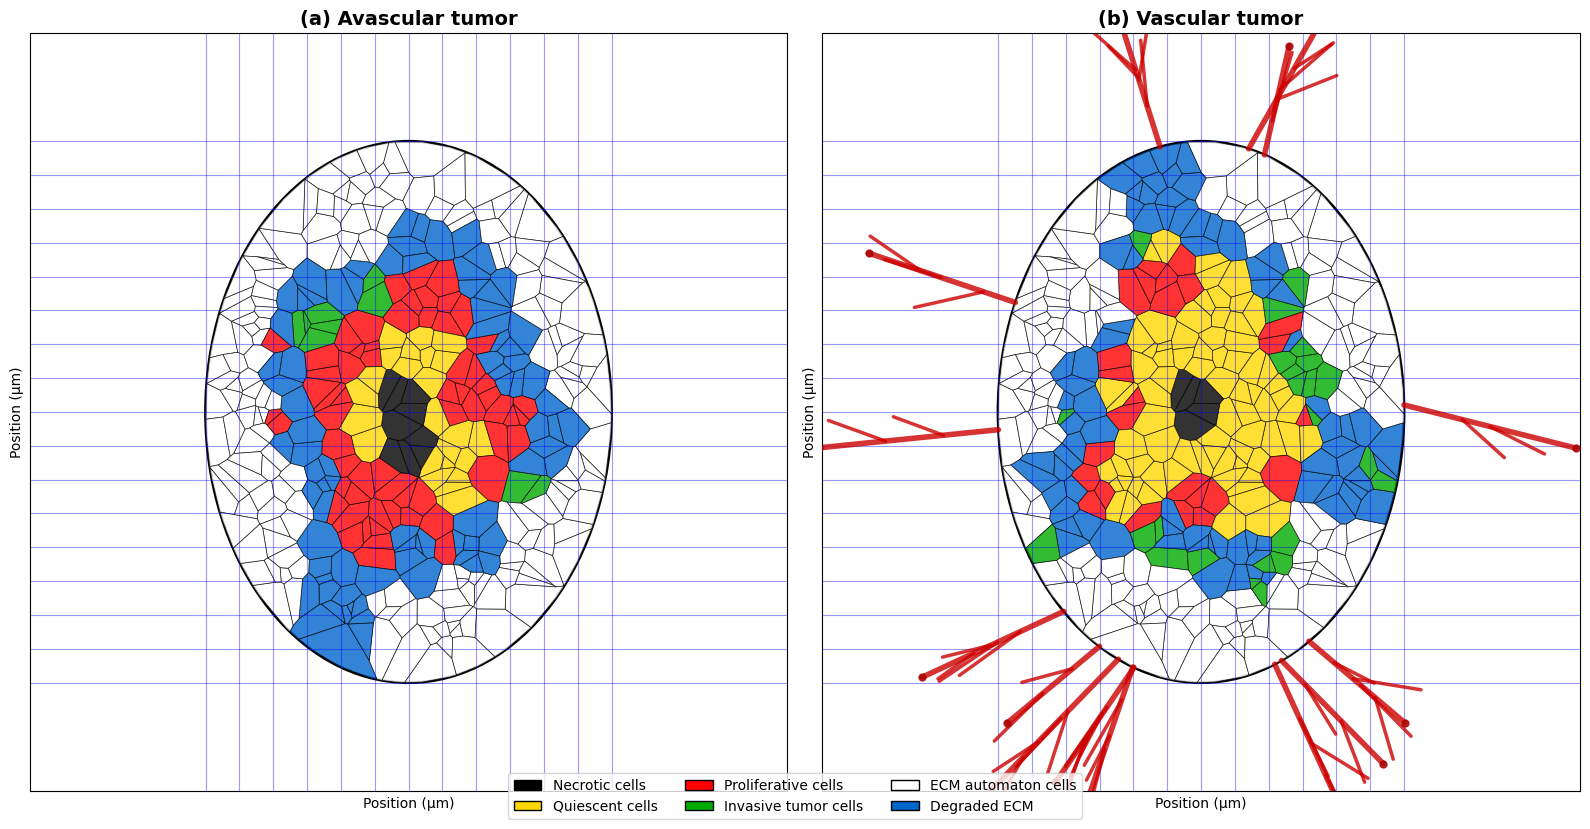

In [25]:
if __name__ == "__main__":
    # Create model instance with corrected orientation
    model = VoronoiTumorModel(a=45, b=60, n_seeds=350)  # a=width, b=height
    
    # Plot both models
    fig = model.plot_model(model_type='both')
    plt.show()

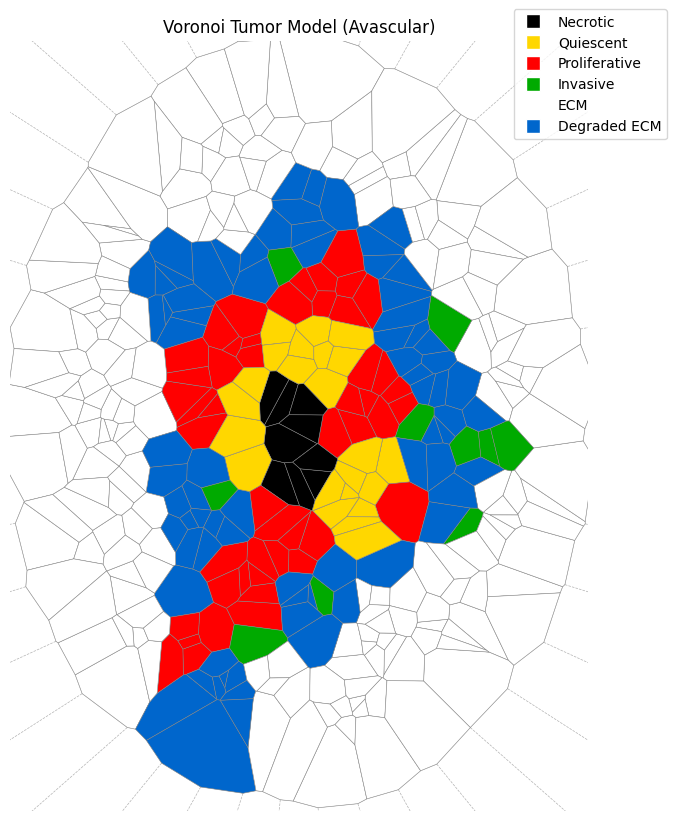


Tissue Type Distribution (Avascular Mode):

Necrotic       :   9 cells ( 2.57%)
Quiescent      :  23 cells ( 6.57%)
Proliferative  :  48 cells (13.71%)
Invasive       :  10 cells ( 2.86%)
ECM            : 185 cells (52.86%)
Degraded ECM   :  75 cells (21.43%)


{'Necrotic': (9, 2.571428571428571),
 'Quiescent': (23, 6.571428571428571),
 'Proliferative': (48, 13.714285714285715),
 'Invasive': (10, 2.857142857142857),
 'ECM': (185, 52.85714285714286),
 'Degraded ECM': (75, 21.428571428571427)}

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from collections import Counter

class VoronoiTumorModel:
    def __init__(self, a=45, b=60, n_seeds=350, mode='avascular'):
        self.a = a
        self.b = b
        self.n_seeds = n_seeds
        self.mode = mode.lower()

        # Cell types
        self.NECROTIC = 0
        self.QUIESCENT = 1
        self.PROLIFERATIVE = 2
        self.INVASIVE = 3
        self.ECM = 4
        self.DEGRADED_ECM = 5

        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',
            self.PROLIFERATIVE: '#FF0000',
            self.INVASIVE: '#00AA00',
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'
        }

        self.labels = {
            self.NECROTIC: 'Necrotic',
            self.QUIESCENT: 'Quiescent',
            self.PROLIFERATIVE: 'Proliferative',
            self.INVASIVE: 'Invasive',
            self.ECM: 'ECM',
            self.DEGRADED_ECM: 'Degraded ECM'
        }

        self.generate_voronoi()
        self.assign_cell_types()

    def is_inside_ellipse(self, x, y, scale=1.0):
        return (x**2 / (self.a * scale)**2) + (y**2 / (self.b * scale)**2) <= 1

    def ellipse_distance(self, x, y):
        return np.sqrt((x**2 / self.a**2) + (y**2 / self.b**2))

    def generate_voronoi(self):
        np.random.seed(42)
        points = []
        for _ in range(self.n_seeds):
            for _ in range(100):
                x = np.random.uniform(-self.a * 0.95, self.a * 0.95)
                y = np.random.uniform(-self.b * 0.95, self.b * 0.95)
                if self.is_inside_ellipse(x, y, scale=0.95):
                    points.append([x, y])
                    break
        self.points = np.array(points)

        # Add boundary points to close Voronoi edges
        boundary_points = [[self.a * 1.3 * np.cos(theta), self.b * 1.3 * np.sin(theta)]
                           for theta in np.linspace(0, 2*np.pi, 40, endpoint=False)]
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)

    def assign_cell_types(self):
        if self.mode == 'avascular':
            self.assign_avascular()
        elif self.mode == 'vascular':
            self.assign_vascular()
        else:
            raise ValueError("Mode must be 'avascular' or 'vascular'.")

    def assign_avascular(self):
        self.cell_types = []
        for x, y in self.points:
            dist = self.ellipse_distance(x, y)
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.12 * np.sin(4 * angle) + 0.08 * np.sin(7 * angle)
            effective_dist = dist * irregularity

            if effective_dist < 0.18:
                self.cell_types.append(self.NECROTIC)
            elif effective_dist < 0.32:
                self.cell_types.append(self.QUIESCENT)
            elif effective_dist < 0.48:
                self.cell_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.68:
                self.cell_types.append(self.DEGRADED_ECM if random.random() < 0.85 else self.PROLIFERATIVE)
            else:
                self.cell_types.append(self.ECM)

        self.smooth_cell_types()
        self.add_invasive_clusters()

    def assign_vascular(self):
        self.cell_types = []
        for x, y in self.points:
            dist = self.ellipse_distance(x, y)
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.1 * np.sin(5 * angle) + 0.05 * np.sin(9 * angle)
            effective_dist = dist * irregularity

            if effective_dist < 0.1:
                self.cell_types.append(self.NECROTIC)
            elif effective_dist < 0.3:
                self.cell_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.5:
                self.cell_types.append(self.INVASIVE)
            elif effective_dist < 0.7:
                self.cell_types.append(self.DEGRADED_ECM)
            else:
                self.cell_types.append(self.ECM)

        self.smooth_cell_types()
        self.add_invasive_clusters()

    def smooth_cell_types(self):
        for _ in range(6):
            new_types = self.cell_types.copy()
            for i, point in enumerate(self.points):
                distances = np.linalg.norm(self.points - point, axis=1)
                neighbors = np.where((distances < max(self.a, self.b) * 0.1) & (distances > 0))[0]

                if len(neighbors) > 1:
                    neighbor_types = [self.cell_types[j] for j in neighbors]
                    type_counts = Counter(neighbor_types)
                    dominant_type, count = type_counts.most_common(1)[0]
                    if count >= len(neighbors) * 0.55:
                        new_types[i] = dominant_type
            self.cell_types = new_types

    def add_invasive_clusters(self):
        for i, t in enumerate(self.cell_types):
            if t == self.DEGRADED_ECM and random.random() < 0.1:
                self.cell_types[i] = self.INVASIVE

    def visualize(self):
        fig, ax = plt.subplots(figsize=(8, 10))
        voronoi_plot_2d(self.vor, ax=ax, show_vertices=False, line_colors='gray',
                        line_width=0.5, line_alpha=0.6, point_size=0)

        for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
            region = self.vor.regions[region_idx]
            if not -1 in region and len(region) > 0:
                polygon = [self.vor.vertices[i] for i in region]
                ax.fill(*zip(*polygon), color=self.colors[self.cell_types[i]], edgecolor='gray', linewidth=0.2)

        handles = [plt.Line2D([0], [0], marker='s', color='w', label=self.labels[ct],
                              markerfacecolor=self.colors[ct], markersize=10)
                   for ct in sorted(self.colors)]
        ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 1.05))

        ax.set_xlim(-self.a * 1.1, self.a * 1.1)
        ax.set_ylim(-self.b * 1.1, self.b * 1.1)
        ax.set_aspect('equal')
        ax.axis('off')
        plt.title(f"Voronoi Tumor Model ({self.mode.capitalize()})")
        plt.show()

    def statistics(self):
        counts = Counter(self.cell_types)
        total = sum(counts.values())
        stats = {self.labels[k]: (counts.get(k, 0), counts.get(k, 0)/total*100) for k in range(6)}
        print(f"\nTissue Type Distribution ({self.mode.capitalize()} Mode):\n")
        for label, (count, pct) in stats.items():
            print(f"{label:<15}: {count:>3} cells ({pct:>5.2f}%)")
        return stats


# Example usage
model = VoronoiTumorModel(mode='avascular')  # or 'vascular'
model.visualize()
model.statistics()


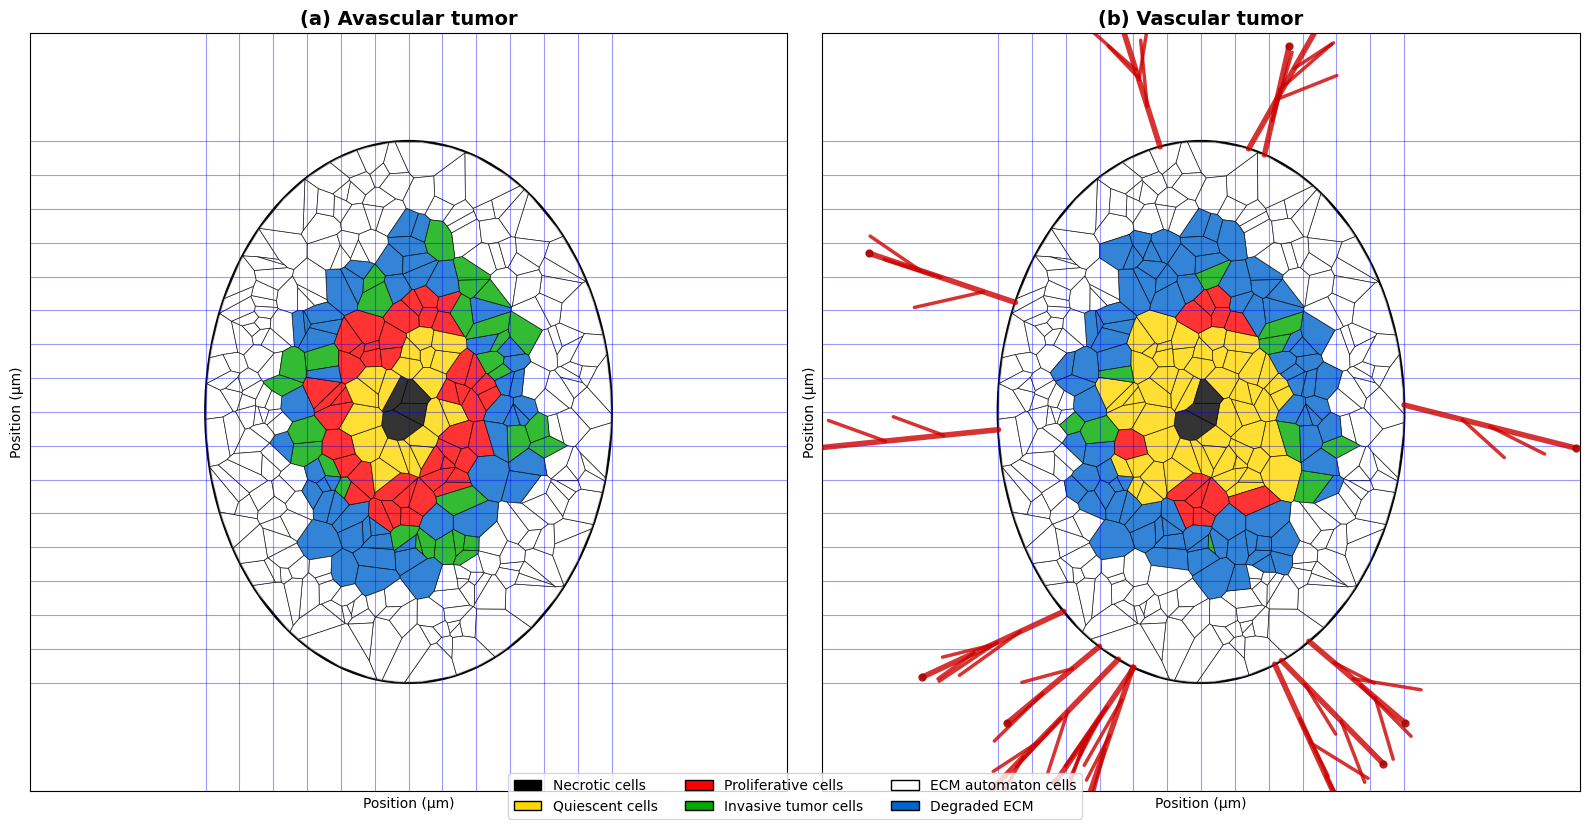

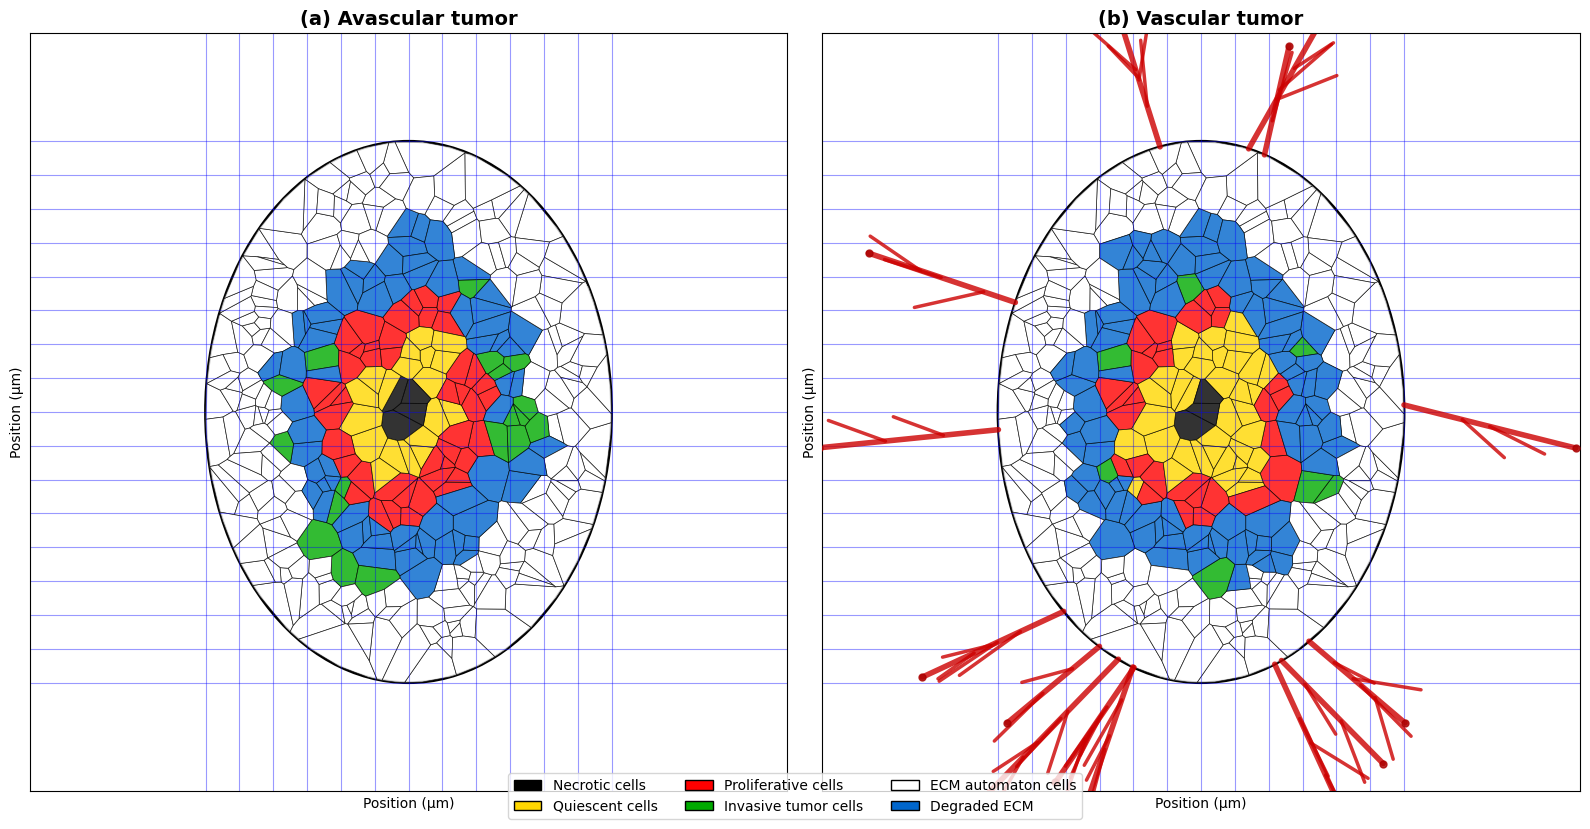

Compact Rim Tumor Model Statistics:
Necrotic       :   3 cells (  0.9%)
Quiescent      :  37 cells ( 10.6%)
Proliferative  :  29 cells (  8.3%)
Invasive       :   7 cells (  2.0%)
ECM            : 186 cells ( 53.1%)
Degraded ECM   :  88 cells ( 25.1%)

Total cells: 350
Ellipse dimensions: 90 × 120 μm (width × height)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon, Ellipse
import random
%matplotlib inline
class VoronoiTumorModel:
    def __init__(self, a=45, b=60, n_seeds=350):
        """
        Initialize the Voronoi tumor model with oval domain
        
        Parameters:
        a: semi-minor axis (x-axis) - now smaller
        b: semi-major axis (y-direction) - now larger  
        n_seeds: number of Voronoi seeds (cells)
        """
        self.a = a  # semi-minor axis (x-direction)
        self.b = b  # semi-major axis (y-direction) 
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black - core
        self.QUIESCENT = 1     # Yellow - around core
        self.PROLIFERATIVE = 2 # Red - active region
        self.INVASIVE = 3      # Green - scattered in degraded ECM
        self.ECM = 4           # White - outer region
        self.DEGRADED_ECM = 5  # Blue - invasion zone
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types_avascular()
    
    def is_inside_ellipse(self, x, y, scale=1.0):
        """Check if point is inside ellipse"""
        return (x**2 / (self.a * scale)**2) + (y**2 / (self.b * scale)**2) <= 1
    
    def ellipse_distance(self, x, y):
        """Calculate normalized distance from ellipse center (0 at center, 1 at boundary)"""
        return np.sqrt((x**2 / self.a**2) + (y**2 / self.b**2))
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within oval domain"""
        np.random.seed(42)
        
        points = []
        
        # Generate points with higher density in tumor core
        for _ in range(self.n_seeds):
            # Use rejection sampling to generate points in ellipse
            attempts = 0
            while attempts < 100:
                # Generate in bounding rectangle
                x = np.random.uniform(-self.a * 0.95, self.a * 0.95)
                y = np.random.uniform(-self.b * 0.95, self.b * 0.95)
                
                if self.is_inside_ellipse(x, y, scale=0.95):
                    points.append([x, y])
                    break
                attempts += 1
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 40, endpoint=False):
            x = self.a * 1.3 * np.cos(theta)
            y = self.b * 1.3 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
    
    def assign_cell_types_avascular(self):
        """Assign cell types for avascular model - compact concentric rims like in the figure"""
        self.cell_types = []
        
        # First pass: assign base cell types by elliptical distance with tighter boundaries
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Minimal irregularity to maintain compact rim structure
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.05 * np.sin(4 * angle) + 0.03 * np.sin(7 * angle)
            effective_dist = norm_dist * irregularity
            
            # Compact layered structure with tighter boundaries
            if effective_dist < 0.12:  # Very compact necrotic core
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.25:  # Clear quiescent rim around necrotic core
                base_types.append(self.QUIESCENT)  
            elif effective_dist < 0.40:  # Distinct proliferative rim
                base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.65:  # Degraded ECM region with some invasive
                if random.random() < 0.75:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # ECM region
                base_types.append(self.ECM)
        
        # Second pass: Very strong clustering for compact rim formation
        self.cell_types = base_types.copy()
        
        # Many iterations with very strong clustering to create distinct rims
        for iteration in range(12):  # More iterations for very compact rims
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                # Find nearby points for clustering - smaller radius for tighter rims
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                cluster_radius = max(self.a, self.b) * 0.08  # Smaller clustering radius
                nearby_indices = np.where((distances < cluster_radius) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:  # Need more neighbors for strong clustering
                    # Count cell types in neighborhood
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    # Find dominant type
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        # Very strong clustering - switch if majority neighbors are same type
                        clustering_threshold = 0.6 if iteration < 6 else 0.5  # Start strict, then relax slightly
                        if dominant_count >= len(nearby_indices) * clustering_threshold:
                            # Only switch to compatible types within same general zone
                            current_zone = self.get_cell_zone_compact(point)
                            if self.is_compatible_type_compact(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Third pass: Final rim enforcement - ensure no isolated cells break rim structure
        self.enforce_rim_structure()
        
        # Fourth pass: Create small invasive cell clusters within degraded ECM
        self.add_invasive_clusters_in_degraded_ecm()
    
    def enforce_rim_structure(self):
        """Enforce compact rim structure by removing isolated cells that break the pattern"""
        for _ in range(3):  # Multiple passes to clean up isolated cells
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                current_type = self.cell_types[i]
                
                # Find immediate neighbors
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                neighbor_radius = max(self.a, self.b) * 0.06  # Very tight neighborhood
                nearby_indices = np.where((distances < neighbor_radius) & (distances > 0))[0]
                
                if len(nearby_indices) > 1:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    
                    # If this cell is isolated (different from most neighbors), convert it
                    same_type_count = nearby_types.count(current_type)
                    if same_type_count < len(nearby_types) * 0.4:  # Less than 40% same type
                        # Find most common neighbor type
                        type_counts = {}
                        for cell_type in nearby_types:
                            type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                        
                        if type_counts:
                            most_common_type = max(type_counts, key=type_counts.get)
                            
                            # Check if conversion maintains rim structure
                            current_zone = self.get_cell_zone_compact(point)
                            if self.is_compatible_type_compact(most_common_type, current_zone):
                                new_types[i] = most_common_type
            
            self.cell_types = new_types
    
    def assign_cell_types_vascular(self):
        """Assign cell types for vascular model - compact rims but less proliferative"""
        self.cell_types = []
        
        # Vascular tumors have different morphology due to blood supply
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Minimal irregularity for compact structure
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.06 * np.sin(3 * angle) + 0.04 * np.sin(6 * angle)
            effective_dist = norm_dist * irregularity
            
            # Vascular model: smaller necrotic core, larger quiescent rim, less proliferative
            if effective_dist < 0.08:  # Smaller necrotic core due to better oxygenation
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.30:  # Larger quiescent rim in vascular model
                base_types.append(self.QUIESCENT)
            elif effective_dist < 0.42:  # Smaller proliferative zone
                if random.random() < 0.6:  # Less proliferative compared to avascular
                    base_types.append(self.PROLIFERATIVE)
                else:
                    base_types.append(self.QUIESCENT)  # More quiescent instead
            elif effective_dist < 0.67:  # Degraded ECM with invasive cells
                if random.random() < 0.8:
                    base_types.append(self.DEGRADED_ECM)
                else:
                    base_types.append(self.INVASIVE)
            else:
                # ECM region
                base_types.append(self.ECM)
        
        # Apply same strong clustering logic for compact rims
        self.cell_types = base_types.copy()
        
        # Strong clustering iterations for vascular model
        for iteration in range(10):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                cluster_radius = max(self.a, self.b) * 0.08
                nearby_indices = np.where((distances < cluster_radius) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        clustering_threshold = 0.55
                        if dominant_count >= len(nearby_indices) * clustering_threshold:
                            current_zone = self.get_cell_zone_compact(point)
                            if self.is_compatible_type_compact(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Enforce rim structure for vascular model too
        self.enforce_rim_structure()
        
        # Add fewer invasive clusters in vascular model
        self.add_invasive_clusters_in_degraded_ecm_vascular()
    
    def get_cell_zone_compact(self, point):
        """Determine which zone a point is in for compact rim structure"""
        norm_dist = self.ellipse_distance(point[0], point[1])
        
        if norm_dist < 0.15:
            return 'necrotic_core'
        elif norm_dist < 0.28:
            return 'quiescent_rim'
        elif norm_dist < 0.45:
            return 'proliferative_rim'
        elif norm_dist < 0.70:
            return 'invasion_zone'
        else:
            return 'ecm_region'
    
    def is_compatible_type_compact(self, cell_type, zone):
        """Check if cell type is compatible with compact rim zone"""
        compatible = {
            'necrotic_core': [self.NECROTIC],  # Only necrotic in core
            'quiescent_rim': [self.QUIESCENT, self.NECROTIC],  # Mainly quiescent, some necrotic
            'proliferative_rim': [self.PROLIFERATIVE, self.QUIESCENT],  # Mainly proliferative, some quiescent
            'invasion_zone': [self.DEGRADED_ECM, self.INVASIVE, self.PROLIFERATIVE],
            'ecm_region': [self.ECM, self.DEGRADED_ECM]
        }
        return cell_type in compatible.get(zone, [])
    
    def add_invasive_clusters_in_degraded_ecm(self):
        """Add small green invasive cell clusters within blue degraded ECM regions (avascular)"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create several small invasive clusters within degraded ECM
        for _ in range(6):  # More clusters for avascular model
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive (small green clusters)
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.05  # Small clusters
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert some to invasive cells (small green clusters in blue regions)
                cluster_cells = min(len(nearby_degraded), random.randint(2, 5))
                for idx in nearby_degraded[:cluster_cells]:
                    if random.random() < 0.8:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def add_invasive_clusters_in_degraded_ecm_vascular(self):
        """Add invasive cell clusters for vascular model - fewer and smaller"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create fewer invasive clusters in vascular model
        for _ in range(4):  # Fewer clusters than avascular
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.04  # Smaller clusters than avascular
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert fewer to invasive cells
                cluster_cells = min(len(nearby_degraded), random.randint(1, 3))
                for idx in nearby_degraded[:cluster_cells]:
                    if random.random() < 0.7:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def clip_polygon_to_ellipse(self, vertices):
        """Clip polygon vertices to elliptical boundary"""
        clipped_vertices = []
        for vertex in vertices:
            if self.is_inside_ellipse(vertex[0], vertex[1]):
                clipped_vertices.append(vertex)
            else:
                # Project point onto ellipse boundary
                # Find closest point on ellipse
                x, y = vertex[0], vertex[1]
                # Simple approximation - scale to ellipse boundary
                norm_dist = self.ellipse_distance(x, y)
                if norm_dist > 0:
                    scale = 1.0 / norm_dist
                    clipped_vertices.append([x * scale, y * scale])
                else:
                    clipped_vertices.append(vertex)
        return np.array(clipped_vertices) if clipped_vertices else vertices
    
    def plot_model(self, model_type='both', show_grid=True, figsize=(16, 8)):
        """Plot the Voronoi tumor model with compact rim structure matching the figure"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            
            # Generate different cell distributions for each model
            self.assign_cell_types_avascular()
            avascular_types = self.cell_types.copy()
            
            self.assign_cell_types_vascular()
            vascular_types = self.cell_types.copy()
            
            cell_type_sets = [avascular_types, vascular_types]
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            
            if model_type == 'vascular':
                self.assign_cell_types_vascular()
            else:
                self.assign_cell_types_avascular()
            
            cell_type_sets = [self.cell_types]
            vessel_flags = [model_type == 'vascular']
        
        for idx, (ax, title, current_cell_types, show_vessels_flag) in enumerate(zip(axes, titles, cell_type_sets, vessel_flags)):
            # Set up the plot - note: b is now the larger dimension (y-axis)
            plot_margin = max(self.a, self.b) * 1.4
            ax.set_xlim(-plot_margin, plot_margin)
            ax.set_ylim(-plot_margin, plot_margin)
            ax.set_aspect('equal')
            
            # Draw elliptical boundary - now taller than wide
            ellipse = Ellipse((0, 0), 2*self.a, 2*self.b, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(ellipse)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to elliptical boundary
                clipped_vertices = self.clip_polygon_to_ellipse(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within ellipse
                    cell_center = self.points[i]
                    if self.is_inside_ellipse(cell_center[0], cell_center[1]):
                        color = self.colors[current_cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = max(self.a, self.b) / 8
                x_range = np.arange(-self.a, self.a + grid_spacing, grid_spacing)
                y_range = np.arange(-self.b, self.b + grid_spacing, grid_spacing)
                
                for x in x_range:
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in y_range:
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model (outside the ellipse)
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels floating outside the oval domain"""
        np.random.seed(123)
        n_vessels = 14
        
        for _ in range(n_vessels):
            # Random position on the ellipse boundary
            theta = np.random.uniform(0, 2*np.pi)
            boundary_x = self.a * np.cos(theta)
            boundary_y = self.b * np.sin(theta)
            
            # Vessel extends outward from boundary
            vessel_length = np.random.uniform(max(self.a, self.b) * 0.4, max(self.a, self.b) * 0.8)
            
            # Direction: outward normal to ellipse + some randomness
            # Normal to ellipse at point (a*cos(t), b*sin(t)) is (cos(t)/a, sin(t)/b)
            normal_x = np.cos(theta) / self.a
            normal_y = np.sin(theta) / self.b
            # Normalize the normal vector
            normal_length = np.sqrt(normal_x**2 + normal_y**2)
            normal_x /= normal_length
            normal_y /= normal_length
            
            # Add some randomness to the direction
            random_angle = np.random.uniform(-0.3, 0.3)
            cos_r, sin_r = np.cos(random_angle), np.sin(random_angle)
            dir_x = normal_x * cos_r - normal_y * sin_r
            dir_y = normal_x * sin_r + normal_y * cos_r
            
            # Main vessel trunk extending outward
            trunk_end_x = boundary_x + vessel_length * dir_x
            trunk_end_y = boundary_y + vessel_length * dir_y
            
            # Draw main vessel trunk
            ax.plot([boundary_x, trunk_end_x], [boundary_y, trunk_end_y], 
                   color='#CC0000', linewidth=4, alpha=0.8, solid_capstyle='round')
            
            # Add branching vessels
            n_branches = np.random.randint(2, 5)
            for i in range(n_branches):
                # Branch point along the trunk
                branch_ratio = 0.3 + (0.5 * i / n_branches) + np.random.uniform(-0.1, 0.1)
                branch_x = boundary_x + branch_ratio * (trunk_end_x - boundary_x)
                branch_y = boundary_y + branch_ratio * (trunk_end_y - boundary_y)
                
                # Branch direction
                branch_angle = np.arctan2(dir_y, dir_x) + np.random.uniform(-0.7, 0.7)
                branch_length = np.random.uniform(max(self.a, self.b) * 0.15, max(self.a, self.b) * 0.3)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                # Draw branch
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='#CC0000', linewidth=2.5, alpha=0.8, solid_capstyle='round')
            
            # Add vessel endpoint
            ax.scatter(trunk_end_x, trunk_end_y, c='#AA0000', s=25, alpha=0.8, zorder=5)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Compact Rim Tumor Model Statistics:")
        print("=" * 40)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Ellipse dimensions: {2*self.a} × {2*self.b} μm (width × height)")

# Example usage:
if __name__ == "__main__":
    # Create and visualize the compact rim tumor model
    model = VoronoiTumorModel(a=45, b=60, n_seeds=350)
    
    # Plot both models
    fig = model.plot_model(model_type='both', show_grid=True)
    plt.show()
    
    # Get statistics
    model.get_statistics()

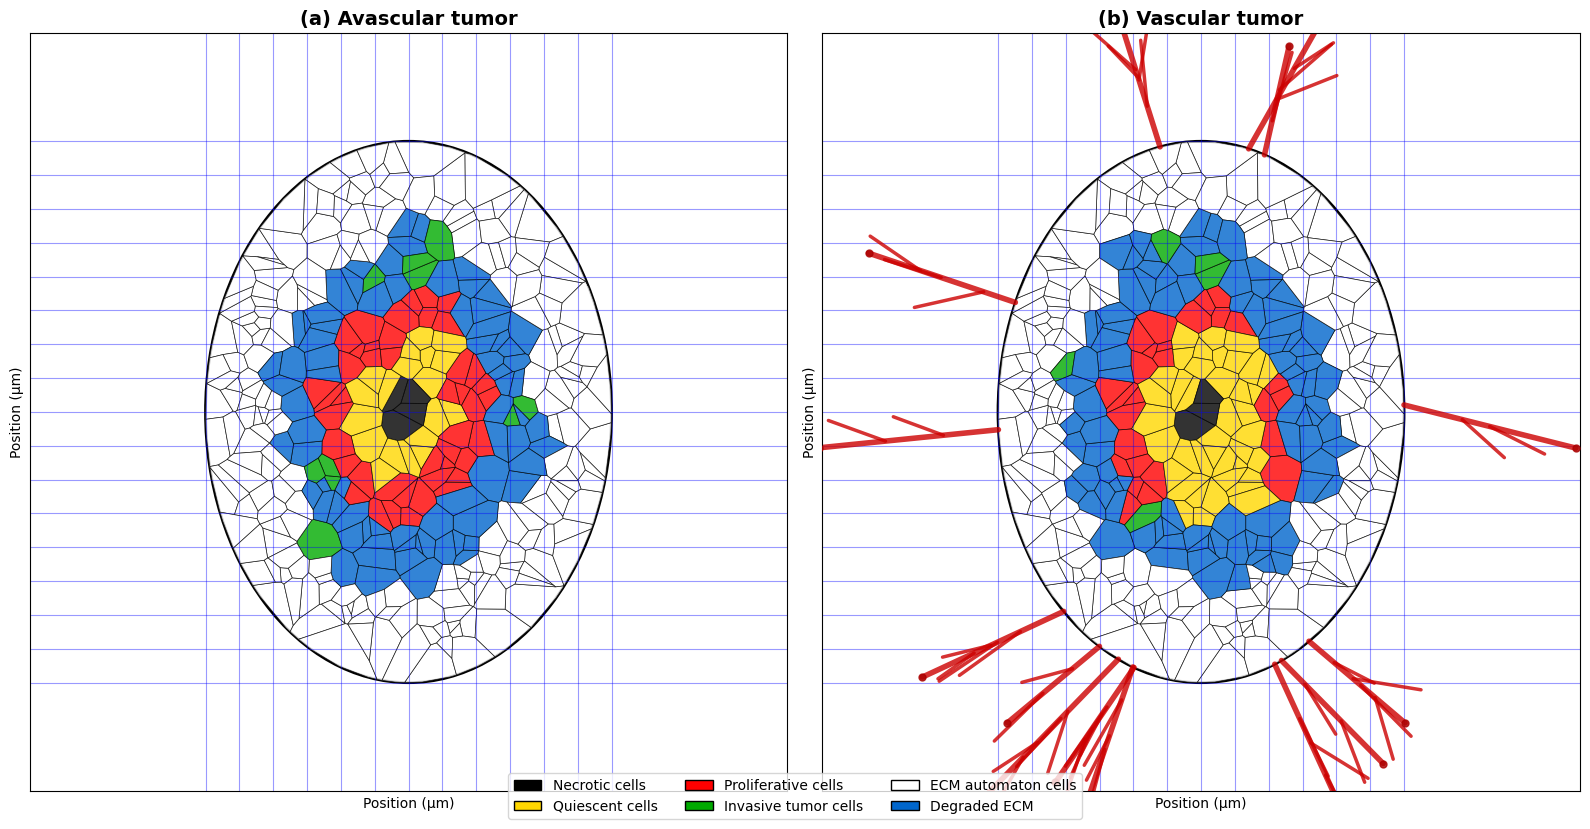

Compact Rim Tumor Model Statistics:
Necrotic       :   3 cells (  0.9%)
Quiescent      :  40 cells ( 11.4%)
Proliferative  :  27 cells (  7.7%)
Invasive       :   5 cells (  1.4%)
ECM            : 186 cells ( 53.1%)
Degraded ECM   :  89 cells ( 25.4%)

Total cells: 350
Ellipse dimensions: 90 × 120 μm (width × height)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon, Ellipse
import random

class VoronoiTumorModel:
    def __init__(self, a=45, b=60, n_seeds=350):
        """
        Initialize the Voronoi tumor model with oval domain
        
        Parameters:
        a: semi-minor axis (x-axis) - now smaller
        b: semi-major axis (y-direction) - now larger  
        n_seeds: number of Voronoi seeds (cells)
        """
        self.a = a  # semi-minor axis (x-direction)
        self.b = b  # semi-major axis (y-direction) 
        self.n_seeds = n_seeds
        self.center = np.array([0, 0])
        
        # Cell type definitions matching the paper
        self.NECROTIC = 0      # Black - core
        self.QUIESCENT = 1     # Yellow - around core
        self.PROLIFERATIVE = 2 # Red - active region
        self.INVASIVE = 3      # Green - scattered in degraded ECM
        self.ECM = 4           # White - outer region
        self.DEGRADED_ECM = 5  # Blue - invasion zone
        
        # Color mapping to match paper
        self.colors = {
            self.NECROTIC: 'black',
            self.QUIESCENT: '#FFD700',  # Gold/yellow
            self.PROLIFERATIVE: '#FF0000',  # Red
            self.INVASIVE: '#00AA00',   # Green
            self.ECM: 'white',
            self.DEGRADED_ECM: '#0066CC'  # Blue
        }
        
        self.generate_voronoi()
        self.assign_cell_types_avascular()
    
    def is_inside_ellipse(self, x, y, scale=1.0):
        """Check if point is inside ellipse"""
        return (x**2 / (self.a * scale)**2) + (y**2 / (self.b * scale)**2) <= 1
    
    def ellipse_distance(self, x, y):
        """Calculate normalized distance from ellipse center (0 at center, 1 at boundary)"""
        return np.sqrt((x**2 / self.a**2) + (y**2 / self.b**2))
    
    def generate_voronoi(self):
        """Generate Voronoi diagram within oval domain"""
        np.random.seed(42)
        
        points = []
        
        # Generate points with higher density in tumor core
        for _ in range(self.n_seeds):
            # Use rejection sampling to generate points in ellipse
            attempts = 0
            while attempts < 100:
                # Generate in bounding rectangle
                x = np.random.uniform(-self.a * 0.95, self.a * 0.95)
                y = np.random.uniform(-self.b * 0.95, self.b * 0.95)
                
                if self.is_inside_ellipse(x, y, scale=0.95):
                    points.append([x, y])
                    break
                attempts += 1
        
        self.points = np.array(points)
        
        # Add boundary points to ensure proper Voronoi cells near edges
        boundary_points = []
        for theta in np.linspace(0, 2*np.pi, 40, endpoint=False):
            x = self.a * 1.3 * np.cos(theta)
            y = self.b * 1.3 * np.sin(theta)
            boundary_points.append([x, y])
        
        all_points = np.vstack([self.points, boundary_points])
        self.vor = Voronoi(all_points)
    
    def assign_cell_types_avascular(self):
        """Assign cell types for avascular model - compact concentric rims like in the figure"""
        self.cell_types = []
        
        # First pass: assign base cell types by elliptical distance with tighter boundaries
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Minimal irregularity to maintain compact rim structure
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.05 * np.sin(4 * angle) + 0.03 * np.sin(7 * angle)
            effective_dist = norm_dist * irregularity
            
            # Compact layered structure with tighter boundaries
            if effective_dist < 0.12:  # Very compact necrotic core
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.25:  # Clear quiescent rim around necrotic core
                base_types.append(self.QUIESCENT)  
            elif effective_dist < 0.40:  # Distinct proliferative rim
                base_types.append(self.PROLIFERATIVE)
            elif effective_dist < 0.65:  # Degraded ECM region
                base_types.append(self.DEGRADED_ECM)
            else:
                # ECM region
                base_types.append(self.ECM)
        
        # Second pass: Very strong clustering for compact rim formation
        self.cell_types = base_types.copy()
        
        # Many iterations with very strong clustering to create distinct rims
        for iteration in range(12):  # More iterations for very compact rims
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                # Find nearby points for clustering - smaller radius for tighter rims
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                cluster_radius = max(self.a, self.b) * 0.08  # Smaller clustering radius
                nearby_indices = np.where((distances < cluster_radius) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:  # Need more neighbors for strong clustering
                    # Count cell types in neighborhood
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    # Find dominant type
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        # Very strong clustering - switch if majority neighbors are same type
                        clustering_threshold = 0.6 if iteration < 6 else 0.5  # Start strict, then relax slightly
                        if dominant_count >= len(nearby_indices) * clustering_threshold:
                            # Only switch to compatible types within same general zone
                            current_zone = self.get_cell_zone_compact(point)
                            if self.is_compatible_type_compact(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Third pass: Final rim enforcement - ensure no isolated cells break rim structure
        self.enforce_rim_structure()
        
        # Fourth pass: Create small invasive cell clusters within degraded ECM
        self.add_invasive_clusters_in_degraded_ecm()
    
    def enforce_rim_structure(self):
        """Enforce compact rim structure by removing isolated cells that break the pattern"""
        for _ in range(3):  # Multiple passes to clean up isolated cells
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                current_type = self.cell_types[i]
                
                # Find immediate neighbors
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                neighbor_radius = max(self.a, self.b) * 0.06  # Very tight neighborhood
                nearby_indices = np.where((distances < neighbor_radius) & (distances > 0))[0]
                
                if len(nearby_indices) > 1:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    
                    # If this cell is isolated (different from most neighbors), convert it
                    same_type_count = nearby_types.count(current_type)
                    if same_type_count < len(nearby_types) * 0.4:  # Less than 40% same type
                        # Find most common neighbor type
                        type_counts = {}
                        for cell_type in nearby_types:
                            type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                        
                        if type_counts:
                            most_common_type = max(type_counts, key=type_counts.get)
                            
                            # Check if conversion maintains rim structure
                            current_zone = self.get_cell_zone_compact(point)
                            if self.is_compatible_type_compact(most_common_type, current_zone):
                                new_types[i] = most_common_type
            
            self.cell_types = new_types
    
    def assign_cell_types_vascular(self):
        """Assign cell types for vascular model - compact rims but less proliferative"""
        self.cell_types = []
        
        # Vascular tumors have different morphology due to blood supply
        base_types = []
        for point in self.points:
            x, y = point[0], point[1]
            norm_dist = self.ellipse_distance(x, y)
            
            # Minimal irregularity for compact structure
            angle = np.arctan2(y, x)
            irregularity = 1 + 0.06 * np.sin(3 * angle) + 0.04 * np.sin(6 * angle)
            effective_dist = norm_dist * irregularity
            
            # Vascular model: smaller necrotic core, larger quiescent rim, less proliferative
            if effective_dist < 0.08:  # Smaller necrotic core due to better oxygenation
                base_types.append(self.NECROTIC)
            elif effective_dist < 0.30:  # Larger quiescent rim in vascular model
                base_types.append(self.QUIESCENT)
            elif effective_dist < 0.42:  # Smaller proliferative zone
                if random.random() < 0.6:  # Less proliferative compared to avascular
                    base_types.append(self.PROLIFERATIVE)
                else:
                    base_types.append(self.QUIESCENT)  # More quiescent instead
            elif effective_dist < 0.67:  # Degraded ECM region
                base_types.append(self.DEGRADED_ECM)
            else:
                # ECM region
                base_types.append(self.ECM)
        
        # Apply same strong clustering logic for compact rims
        self.cell_types = base_types.copy()
        
        # Strong clustering iterations for vascular model
        for iteration in range(10):
            new_types = self.cell_types.copy()
            
            for i, point in enumerate(self.points):
                distances = np.sqrt(np.sum((self.points - point)**2, axis=1))
                cluster_radius = max(self.a, self.b) * 0.08
                nearby_indices = np.where((distances < cluster_radius) & (distances > 0))[0]
                
                if len(nearby_indices) > 2:
                    nearby_types = [self.cell_types[j] for j in nearby_indices]
                    type_counts = {}
                    for cell_type in nearby_types:
                        type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
                    
                    if type_counts:
                        dominant_type = max(type_counts, key=type_counts.get)
                        dominant_count = type_counts[dominant_type]
                        
                        clustering_threshold = 0.55
                        if dominant_count >= len(nearby_indices) * clustering_threshold:
                            current_zone = self.get_cell_zone_compact(point)
                            if self.is_compatible_type_compact(dominant_type, current_zone):
                                new_types[i] = dominant_type
            
            self.cell_types = new_types
        
        # Enforce rim structure for vascular model too
        self.enforce_rim_structure()
        
        # Add fewer invasive clusters in vascular model
        self.add_invasive_clusters_in_degraded_ecm_vascular()
    
    def get_cell_zone_compact(self, point):
        """Determine which zone a point is in for compact rim structure"""
        norm_dist = self.ellipse_distance(point[0], point[1])
        
        if norm_dist < 0.15:
            return 'necrotic_core'
        elif norm_dist < 0.28:
            return 'quiescent_rim'
        elif norm_dist < 0.45:
            return 'proliferative_rim'
        elif norm_dist < 0.70:
            return 'invasion_zone'
        else:
            return 'ecm_region'
    
    def is_compatible_type_compact(self, cell_type, zone):
        """Check if cell type is compatible with compact rim zone"""
        compatible = {
            'necrotic_core': [self.NECROTIC],  # Only necrotic in core
            'quiescent_rim': [self.QUIESCENT, self.NECROTIC],  # Mainly quiescent, some necrotic
            'proliferative_rim': [self.PROLIFERATIVE, self.QUIESCENT],  # Mainly proliferative, some quiescent
            'invasion_zone': [self.DEGRADED_ECM, self.INVASIVE, self.PROLIFERATIVE],
            'ecm_region': [self.ECM, self.DEGRADED_ECM]
        }
        return cell_type in compatible.get(zone, [])
    
    def add_invasive_clusters_in_degraded_ecm(self):
        """Add small green invasive cell clusters within blue degraded ECM regions (avascular)"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create several small invasive clusters within degraded ECM
        for _ in range(6):  # More clusters for avascular model
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive (small green clusters)
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.05  # Small clusters
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert some to invasive cells (small green clusters in blue regions)
                cluster_cells = min(len(nearby_degraded), random.randint(2, 5))
                for idx in nearby_degraded[:cluster_cells]:
                    if random.random() < 0.8:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def add_invasive_clusters_in_degraded_ecm_vascular(self):
        """Add invasive cell clusters for vascular model - fewer and smaller"""
        degraded_ecm_indices = [i for i, cell_type in enumerate(self.cell_types) if cell_type == self.DEGRADED_ECM]
        
        # Create fewer invasive clusters in vascular model
        for _ in range(4):  # Fewer clusters than avascular
            if degraded_ecm_indices:
                center_idx = random.choice(degraded_ecm_indices)
                center_point = self.points[center_idx]
                
                # Find nearby degraded ECM cells to convert to invasive
                distances = np.sqrt(np.sum((self.points - center_point)**2, axis=1))
                cluster_size = max(self.a, self.b) * 0.04  # Smaller clusters than avascular
                nearby_degraded = [i for i in degraded_ecm_indices if distances[i] < cluster_size]
                
                # Convert fewer to invasive cells
                cluster_cells = min(len(nearby_degraded), random.randint(1, 3))
                for idx in nearby_degraded[:cluster_cells]:
                    if random.random() < 0.7:
                        self.cell_types[idx] = self.INVASIVE
                        # Remove from degraded_ecm_indices to avoid reusing
                        if idx in degraded_ecm_indices:
                            degraded_ecm_indices.remove(idx)
    
    def clip_polygon_to_ellipse(self, vertices):
        """Clip polygon vertices to elliptical boundary"""
        clipped_vertices = []
        for vertex in vertices:
            if self.is_inside_ellipse(vertex[0], vertex[1]):
                clipped_vertices.append(vertex)
            else:
                # Project point onto ellipse boundary
                # Find closest point on ellipse
                x, y = vertex[0], vertex[1]
                # Simple approximation - scale to ellipse boundary
                norm_dist = self.ellipse_distance(x, y)
                if norm_dist > 0:
                    scale = 1.0 / norm_dist
                    clipped_vertices.append([x * scale, y * scale])
                else:
                    clipped_vertices.append(vertex)
        return np.array(clipped_vertices) if clipped_vertices else vertices
    
    def plot_model(self, model_type='both', show_grid=True, figsize=(16, 8)):
        """Plot the Voronoi tumor model with compact rim structure matching the figure"""
        if model_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            axes = [ax1, ax2]
            titles = ['(a) Avascular tumor', '(b) Vascular tumor']
            
            # Generate different cell distributions for each model
            self.assign_cell_types_avascular()
            avascular_types = self.cell_types.copy()
            
            self.assign_cell_types_vascular()
            vascular_types = self.cell_types.copy()
            
            cell_type_sets = [avascular_types, vascular_types]
            vessel_flags = [False, True]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            axes = [ax]
            titles = [f'{model_type.capitalize()} tumor model']
            
            if model_type == 'vascular':
                self.assign_cell_types_vascular()
            else:
                self.assign_cell_types_avascular()
            
            cell_type_sets = [self.cell_types]
            vessel_flags = [model_type == 'vascular']
        
        for idx, (ax, title, current_cell_types, show_vessels_flag) in enumerate(zip(axes, titles, cell_type_sets, vessel_flags)):
            # Set up the plot - note: b is now the larger dimension (y-axis)
            plot_margin = max(self.a, self.b) * 1.4
            ax.set_xlim(-plot_margin, plot_margin)
            ax.set_ylim(-plot_margin, plot_margin)
            ax.set_aspect('equal')
            
            # Draw elliptical boundary - now taller than wide
            ellipse = Ellipse((0, 0), 2*self.a, 2*self.b, fill=False, edgecolor='black', linewidth=2)
            ax.add_patch(ellipse)
            
            # Plot Voronoi cells
            for i, region_idx in enumerate(self.vor.point_region[:len(self.points)]):
                if region_idx >= len(self.vor.regions):
                    continue
                    
                region = self.vor.regions[region_idx]
                if len(region) == 0 or -1 in region:
                    continue
                
                # Get polygon vertices
                vertices = self.vor.vertices[region]
                
                # Clip to elliptical boundary
                clipped_vertices = self.clip_polygon_to_ellipse(vertices)
                
                if len(clipped_vertices) >= 3:
                    # Check if cell center is within ellipse
                    cell_center = self.points[i]
                    if self.is_inside_ellipse(cell_center[0], cell_center[1]):
                        color = self.colors[current_cell_types[i]]
                        polygon = Polygon(clipped_vertices, facecolor=color, 
                                        edgecolor='black', alpha=0.8, linewidth=0.5)
                        ax.add_patch(polygon)
            
            # Add grid overlay (matching paper's blue grid)
            if show_grid:
                grid_spacing = max(self.a, self.b) / 8
                x_range = np.arange(-self.a, self.a + grid_spacing, grid_spacing)
                y_range = np.arange(-self.b, self.b + grid_spacing, grid_spacing)
                
                for x in x_range:
                    ax.axvline(x, color='blue', alpha=0.4, linewidth=0.8)
                for y in y_range:
                    ax.axhline(y, color='blue', alpha=0.4, linewidth=0.8)
            
            # Add vessels for vascular model (outside the ellipse)
            if show_vessels_flag:
                self.add_vessels(ax)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Position (μm)')
            ax.set_ylabel('Position (μm)')
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        if len(axes) == 1:
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
                      ncol=3, fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def add_vessels(self, ax):
        """Add blood vessels floating outside the oval domain"""
        np.random.seed(123)
        n_vessels = 14
        
        for _ in range(n_vessels):
            # Random position on the ellipse boundary
            theta = np.random.uniform(0, 2*np.pi)
            boundary_x = self.a * np.cos(theta)
            boundary_y = self.b * np.sin(theta)
            
            # Vessel extends outward from boundary
            vessel_length = np.random.uniform(max(self.a, self.b) * 0.4, max(self.a, self.b) * 0.8)
            
            # Direction: outward normal to ellipse + some randomness
            # Normal to ellipse at point (a*cos(t), b*sin(t)) is (cos(t)/a, sin(t)/b)
            normal_x = np.cos(theta) / self.a
            normal_y = np.sin(theta) / self.b
            # Normalize the normal vector
            normal_length = np.sqrt(normal_x**2 + normal_y**2)
            normal_x /= normal_length
            normal_y /= normal_length
            
            # Add some randomness to the direction
            random_angle = np.random.uniform(-0.3, 0.3)
            cos_r, sin_r = np.cos(random_angle), np.sin(random_angle)
            dir_x = normal_x * cos_r - normal_y * sin_r
            dir_y = normal_x * sin_r + normal_y * cos_r
            
            # Main vessel trunk extending outward
            trunk_end_x = boundary_x + vessel_length * dir_x
            trunk_end_y = boundary_y + vessel_length * dir_y
            
            # Draw main vessel trunk
            ax.plot([boundary_x, trunk_end_x], [boundary_y, trunk_end_y], 
                   color='#CC0000', linewidth=4, alpha=0.8, solid_capstyle='round')
            
            # Add branching vessels
            n_branches = np.random.randint(2, 5)
            for i in range(n_branches):
                # Branch point along the trunk
                branch_ratio = 0.3 + (0.5 * i / n_branches) + np.random.uniform(-0.1, 0.1)
                branch_x = boundary_x + branch_ratio * (trunk_end_x - boundary_x)
                branch_y = boundary_y + branch_ratio * (trunk_end_y - boundary_y)
                
                # Branch direction
                branch_angle = np.arctan2(dir_y, dir_x) + np.random.uniform(-0.7, 0.7)
                branch_length = np.random.uniform(max(self.a, self.b) * 0.15, max(self.a, self.b) * 0.3)
                
                branch_end_x = branch_x + branch_length * np.cos(branch_angle)
                branch_end_y = branch_y + branch_length * np.sin(branch_angle)
                
                # Draw branch
                ax.plot([branch_x, branch_end_x], [branch_y, branch_end_y], 
                       color='#CC0000', linewidth=2.5, alpha=0.8, solid_capstyle='round')
            
            # Add vessel endpoint
            ax.scatter(trunk_end_x, trunk_end_y, c='#AA0000', s=25, alpha=0.8, zorder=5)
    
    def get_statistics(self):
        """Get model statistics"""
        cell_counts = {cell_type: self.cell_types.count(cell_type) 
                      for cell_type in range(6)}
        
        total_cells = len(self.cell_types)
        
        print("Compact Rim Tumor Model Statistics:")
        print("=" * 40)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        for i, name in enumerate(cell_names):
            count = cell_counts[i]
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:3d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Ellipse dimensions: {2*self.a} × {2*self.b} μm (width × height)")

# Example usage:
if __name__ == "__main__":
    # Create and visualize the compact rim tumor model
    model = VoronoiTumorModel(a=45, b=60, n_seeds=350)
    
    # Plot both models
    fig = model.plot_model(model_type='both', show_grid=True)
    plt.show()
    
    # Get statistics
    model.get_statistics()

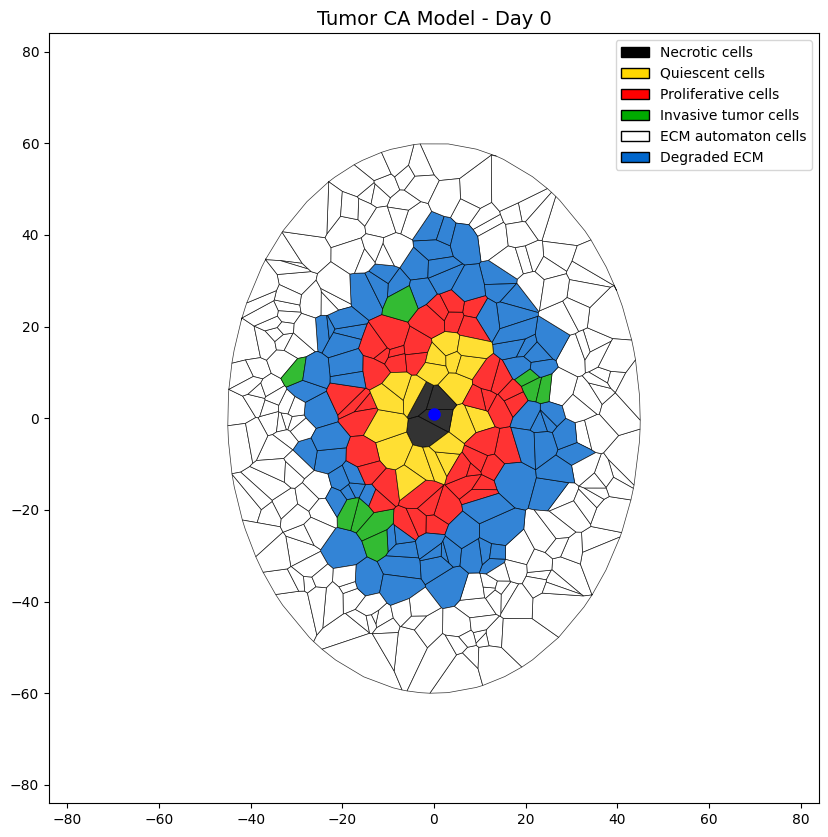

Tumor CA Model Statistics - Day 0
Necrotic       :    4 cells (  1.1%)
Quiescent      :   19 cells (  5.4%)
Proliferative  :   44 cells ( 12.6%)
Invasive       :    9 cells (  2.6%)
ECM            :  199 cells ( 56.9%)
Degraded ECM   :   75 cells ( 21.4%)

Total cells: 350
Tumor centroid: [0.11267256 0.98889778]
Number of invasive paths: 0


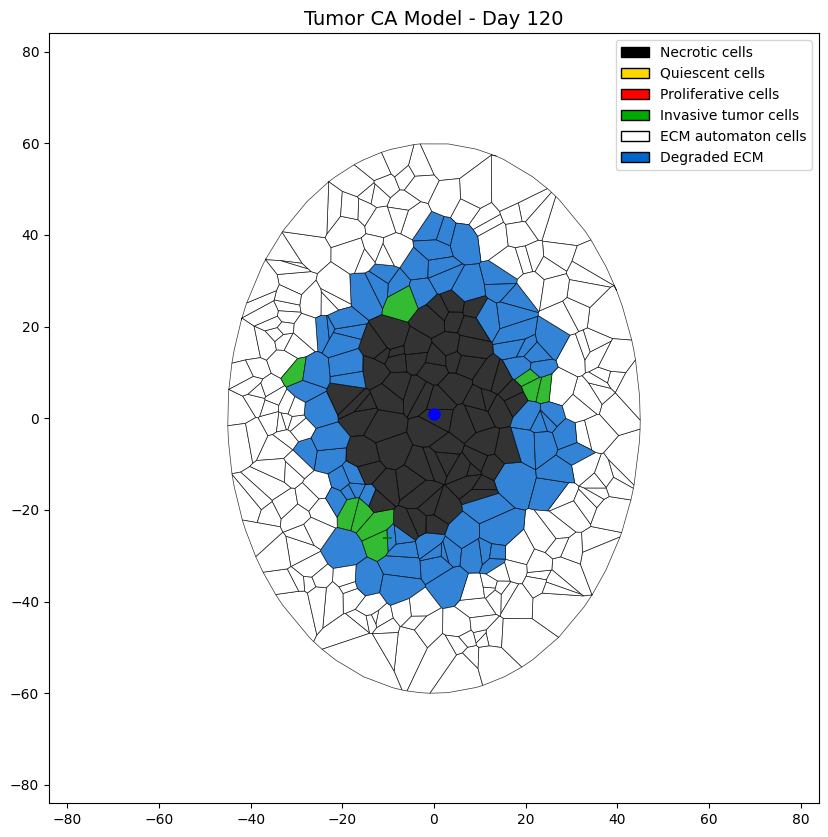

Tumor CA Model Statistics - Day 120
Necrotic       :   67 cells ( 19.1%)
Quiescent      :    0 cells (  0.0%)
Proliferative  :    0 cells (  0.0%)
Invasive       :    9 cells (  2.6%)
ECM            :  199 cells ( 56.9%)
Degraded ECM   :   75 cells ( 21.4%)

Total cells: 350
Tumor centroid: [0.11267256 0.98889778]
Number of invasive paths: 92


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, distance
from scipy.ndimage import gaussian_filter
import random
from collections import defaultdict

class TumorCA:
    def __init__(self, voronoi_model):
        """
        Initialize the CA model using a Voronoi tumor model as input
        
        Parameters:
        voronoi_model: An instance of VoronoiTumorModel containing the initial configuration
        """
        self.voronoi = voronoi_model
        self.points = voronoi_model.points
        self.cell_types = np.array(voronoi_model.cell_types.copy())
        
        # Parameters from Table 1
        self.a = 0.12  # mm^(1/3) - base necrotic thickness scaling
        self.b = 0.08  # mm^(1/3) - base proliferative thickness scaling
        self.p0 = 0.192  # base probability of division
        self.gamma = 0.05  # mutation rate for invasive cells
        self.Ai = 2  # adhesion value
        self.chi = 0.15  # ECM degradation ability
        self.mu = 3  # mobility of invasive cells
        
        # Additional parameters
        self.d = 2  # spatial dimension (2D)
        self.day = 0  # current simulation day
        self.max_days = 120  # maximum simulation days
        
        # ECM density (positively correlated with rigidity)
        self.ecm_density = np.zeros(len(self.points))
        self.initialize_ecm_density()
        
        # Track tumor centroid and edge cells
        self.centroid = None
        self.edge_cells = set()
        self.update_centroid_and_edges()
        
        # Drug concentration (placeholder - could be spatially varying)
        self.drug_concentration = 0.0
        
        # Track invasive cell paths
        self.invasive_paths = []
        
        # For visualization
        self.colors = voronoi_model.colors
    
    def initialize_ecm_density(self):
        """Initialize ECM density based on cell types"""
        for i, cell_type in enumerate(self.cell_types):
            if cell_type == self.voronoi.ECM:
                # Higher density near tumor boundary, lower farther away
                dist_to_tumor = self.distance_to_nearest_tumor(i)
                self.ecm_density[i] = 0.5 + 0.5 * np.exp(-dist_to_tumor / 20.0)
            elif cell_type == self.voronoi.DEGRADED_ECM:
                self.ecm_density[i] = 0.2  # partially degraded
            else:
                self.ecm_density[i] = 0.0  # tumor cells have no ECM
    
    def distance_to_nearest_tumor(self, cell_idx):
        """Calculate distance to nearest tumor cell"""
        tumor_indices = np.where(self.cell_types != self.voronoi.ECM)[0]
        if len(tumor_indices) == 0:
            return 0
        
        distances = distance.cdist([self.points[cell_idx]], self.points[tumor_indices])
        return np.min(distances)
    
    def update_centroid_and_edges(self):
        """Update tumor centroid and identify edge cells"""
        noninvasive_indices = np.where((self.cell_types != self.voronoi.ECM) & 
                                      (self.cell_types != self.voronoi.DEGRADED_ECM) & 
                                      (self.cell_types != self.voronoi.INVASIVE))[0]
        
        if len(noninvasive_indices) == 0:
            self.centroid = np.array([0, 0])
            self.edge_cells = set()
            return
            
        noninvasive_points = self.points[noninvasive_indices]
        self.centroid = np.mean(noninvasive_points, axis=0)
        
        # Find edge cells - tumor cells adjacent to ECM or degraded ECM
        self.edge_cells = set()
        for i in noninvasive_indices:
            for j in self.get_neighbor_indices(i):
                if self.cell_types[j] in [self.voronoi.ECM, self.voronoi.DEGRADED_ECM]:
                    self.edge_cells.add(i)
                    break
    
    def get_neighbor_indices(self, cell_idx, radius=1.5):
        """Get indices of neighboring cells within a certain radius"""
        distances = distance.cdist([self.points[cell_idx]], self.points).flatten()
        return np.where((distances > 0) & (distances < radius))[0]
    
    def calculate_Lt(self, cell_idx):
        """Calculate Lt for a cell - distance from centroid to nearest edge cell in same direction"""
        cell_pos = self.points[cell_idx]
        direction = cell_pos - self.centroid
        if np.linalg.norm(direction) == 0:
            return 0
            
        direction = direction / np.linalg.norm(direction)
        
        min_dist = float('inf')
        for edge_idx in self.edge_cells:
            edge_pos = self.points[edge_idx]
            edge_direction = edge_pos - self.centroid
            if np.linalg.norm(edge_direction) == 0:
                continue
                
            edge_direction = edge_direction / np.linalg.norm(edge_direction)
            # Check if edge cell is in roughly the same direction
            if np.dot(direction, edge_direction) > 0.7:  # ~45 degree cone
                dist = np.linalg.norm(edge_pos - self.centroid)
                if dist < min_dist:
                    min_dist = dist
        
        return min_dist if min_dist != float('inf') else 0
    
    def calculate_Lmax(self, cell_idx):
        """Calculate Lmax - distance to closest growth-permitting boundary in growth direction"""
        cell_pos = self.points[cell_idx]
        direction = cell_pos - self.centroid
        if np.linalg.norm(direction) == 0:
            return 0
            
        direction = direction / np.linalg.norm(direction)
        
        # Find intersection with domain boundary (ellipse)
        a, b = self.voronoi.a, self.voronoi.b
        xc, yc = self.centroid
        dx, dy = direction
        
        # Solve quadratic equation for intersection
        A = (dx**2 / a**2) + (dy**2 / b**2)
        B = (2*xc*dx / a**2) + (2*yc*dy / b**2)
        C = (xc**2 / a**2) + (yc**2 / b**2) - 1
        
        discriminant = B**2 - 4*A*C
        if discriminant < 0:
            return 0
            
        t1 = (-B + np.sqrt(discriminant)) / (2*A)
        t2 = (-B - np.sqrt(discriminant)) / (2*A)
        t = max(t1, t2)  # we want the forward intersection
        
        boundary_point = self.centroid + t * direction
        return np.linalg.norm(boundary_point - self.centroid)
    
    def calculate_Pdiv(self, cell_idx):
        """Calculate division probability for a proliferative cell"""
        r = np.linalg.norm(self.points[cell_idx] - self.centroid)
        Lt = self.calculate_Lt(cell_idx)
        Lmax = self.calculate_Lmax(cell_idx)
        
        if Lmax == 0:
            return 0
            
        # Cellular division reduction factor due to chemotherapy
        Pg_phi = 1 - (1 - 0.5) * self.drug_concentration  # Assuming Pγ=0.5
        
        # Local ECM density for the dividing cell (average of neighbors)
        neighbors = self.get_neighbor_indices(cell_idx)
        if len(neighbors) == 0:
            r_ECM = 0
        else:
            r_ECM = np.mean([self.ecm_density[j] for j in neighbors 
                            if self.cell_types[j] in [self.voronoi.ECM, self.voronoi.DEGRADED_ECM]])
        
        # Division probability formula
        Pdiv = self.p0 * Pg_phi * ((1 - r/Lmax) + (1 - r_ECM)) / 2
        
        # Ensure probability stays within bounds
        return np.clip(Pdiv, 0, 1)
    
    def update_cell_states(self):
        """Update all cell states according to CA rules"""
        new_cell_types = self.cell_types.copy()
        new_ecm_density = self.ecm_density.copy()
        
        # Rule 1: Quiescent cells beyond dn become necrotic
        for i in np.where(self.cell_types == self.voronoi.QUIESCENT)[0]:
            Lt = self.calculate_Lt(i)
            dn = self.a * Lt**((self.d-1)/self.d)
            r = np.linalg.norm(self.points[i] - self.centroid)
            
            if r > dn:
                new_cell_types[i] = self.voronoi.NECROTIC
        
        # Rule 2: Proliferative cells can divide
        proliferative_indices = np.where(self.cell_types == self.voronoi.PROLIFERATIVE)[0]
        random.shuffle(proliferative_indices)  # random order to avoid bias
        
        for i in proliferative_indices:
            # Rule 3: Check if proliferative cell should become quiescent
            Lt = self.calculate_Lt(i)
            dp = self.b * Lt**((self.d-1)/self.d)
            r = np.linalg.norm(self.points[i] - self.centroid)
            
            if r > dp:
                new_cell_types[i] = self.voronoi.QUIESCENT
                continue
                
            # Attempt division
            Pdiv = self.calculate_Pdiv(i)
            if random.random() < Pdiv:
                # Find available ECM neighbor for daughter cell
                neighbors = self.get_neighbor_indices(i)
                ecm_neighbors = [j for j in neighbors 
                                 if self.cell_types[j] in [self.voronoi.ECM, self.voronoi.DEGRADED_ECM]]
                
                if ecm_neighbors:
                    # Choose neighbor with lowest ECM density (easier to invade)
                    ecm_neighbors.sort(key=lambda j: self.ecm_density[j])
                    daughter_idx = ecm_neighbors[0]
                    
                    # Rule 4: Check if daughter becomes invasive
                    if random.random() < self.gamma:
                        # Check adhesion condition
                        tumor_neighbors = [j for j in self.get_neighbor_indices(daughter_idx) 
                                         if self.cell_types[j] not in [self.voronoi.ECM, self.voronoi.DEGRADED_ECM]]
                        if len(tumor_neighbors) < self.Ai:
                            new_cell_types[daughter_idx] = self.voronoi.INVASIVE
                            new_ecm_density[daughter_idx] = 0
                    else:
                        new_cell_types[daughter_idx] = self.voronoi.PROLIFERATIVE
                        new_ecm_density[daughter_idx] = 0
        
        # Rule 5: Invasive cells degrade ECM and migrate
        invasive_indices = np.where(self.cell_types == self.voronoi.INVASIVE)[0]
        for i in invasive_indices:
            # Determine number of movement attempts
            m = random.randint(0, self.mu)
            
            for _ in range(m):
                # Find all ECM neighbors
                neighbors = self.get_neighbor_indices(i)
                ecm_neighbors = [j for j in neighbors 
                                 if self.cell_types[j] in [self.voronoi.ECM, self.voronoi.DEGRADED_ECM]]
                
                if not ecm_neighbors:
                    continue
                    
                # Choose direction with highest nutrient gradient (simplified)
                # In reality, this would depend on oxygen/nutrient concentration
                # Here we just pick a random direction
                target_idx = random.choice(ecm_neighbors)
                
                # Degrade ECM
                degradation = random.uniform(0, self.chi)
                new_ecm_density[target_idx] = max(0, new_ecm_density[target_idx] - degradation)
                
                # If ECM fully degraded, move there
                if new_ecm_density[target_idx] <= 0:
                    # Mark original location as degraded ECM
                    new_cell_types[i] = self.voronoi.DEGRADED_ECM
                    new_ecm_density[i] = 0
                    
                    # Move invasive cell to new location
                    new_cell_types[target_idx] = self.voronoi.INVASIVE
                    new_ecm_density[target_idx] = 0
                    
                    # Record path
                    self.invasive_paths.append((self.points[i], self.points[target_idx]))
                    break
        
        # Update the cell types and ECM density
        self.cell_types = new_cell_types
        self.ecm_density = new_ecm_density
        
        # Update centroid and edge cells for next iteration
        self.update_centroid_and_edges()
    
    def simulate_day(self):
        """Simulate one day of tumor growth"""
        self.update_cell_states()
        self.day += 1
    
    def simulate(self, days=None):
        """Run the simulation for a given number of days"""
        if days is None:
            days = self.max_days - self.day
            
        for _ in range(days):
            if self.day >= self.max_days:
                break
            self.simulate_day()
    
    def plot_state(self, ax=None, show_paths=True):
        """Plot the current state of the tumor"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))
        else:
            fig = ax.get_figure()
        
        # Plot Voronoi cells
        for i, region_idx in enumerate(self.voronoi.vor.point_region[:len(self.points)]):
            if region_idx >= len(self.voronoi.vor.regions):
                continue
                
            region = self.voronoi.vor.regions[region_idx]
            if len(region) == 0 or -1 in region:
                continue
            
            # Get polygon vertices
            vertices = self.voronoi.vor.vertices[region]
            
            # Clip to elliptical boundary
            clipped_vertices = self.voronoi.clip_polygon_to_ellipse(vertices)
            
            if len(clipped_vertices) >= 3:
                # Check if cell center is within ellipse
                cell_center = self.points[i]
                if self.voronoi.is_inside_ellipse(cell_center[0], cell_center[1]):
                    color = self.colors[self.cell_types[i]]
                    polygon = Polygon(clipped_vertices, facecolor=color, 
                                    edgecolor='black', alpha=0.8, linewidth=0.5)
                    ax.add_patch(polygon)
        
        # Plot invasive cell paths
        if show_paths and self.invasive_paths:
            for (start, end) in self.invasive_paths:
                ax.plot([start[0], end[0]], [start[1], end[1]], 
                       'g-', linewidth=1, alpha=0.5)
        
        # Plot tumor centroid
        if self.centroid is not None:
            ax.plot(self.centroid[0], self.centroid[1], 'bo', markersize=8)
        
        # Set plot limits
        plot_margin = max(self.voronoi.a, self.voronoi.b) * 1.4
        ax.set_xlim(-plot_margin, plot_margin)
        ax.set_ylim(-plot_margin, plot_margin)
        ax.set_aspect('equal')
        ax.set_title(f"Tumor CA Model - Day {self.day}", fontsize=14)
        
        # Add legend
        legend_elements = []
        cell_names = ['Necrotic cells', 'Quiescent cells', 'Proliferative cells', 
                     'Invasive tumor cells', 'ECM automaton cells', 'Degraded ECM']
        for i, name in enumerate(cell_names):
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=self.colors[i], 
                                               edgecolor='black', label=name))
        
        ax.legend(handles=legend_elements, loc='upper right')
        
        return fig

    def get_statistics(self):
        """Get current simulation statistics"""
        unique, counts = np.unique(self.cell_types, return_counts=True)
        stats = dict(zip(unique, counts))
        
        print(f"Tumor CA Model Statistics - Day {self.day}")
        print("=" * 40)
        cell_names = ['Necrotic', 'Quiescent', 'Proliferative', 
                     'Invasive', 'ECM', 'Degraded ECM']
        
        total_cells = len(self.cell_types)
        for i, name in enumerate(cell_names):
            count = stats.get(i, 0)
            percentage = (count / total_cells) * 100
            print(f"{name:15}: {count:4d} cells ({percentage:5.1f}%)")
        
        print(f"\nTotal cells: {total_cells}")
        print(f"Tumor centroid: {self.centroid}")
        print(f"Number of invasive paths: {len(self.invasive_paths)}")

# Example usage
if __name__ == "__main__":
    # Create initial Voronoi tumor model
    voronoi_model = VoronoiTumorModel(a=45, b=60, n_seeds=350)
    
    # Create CA model using the Voronoi diagram
    ca_model = TumorCA(voronoi_model)
    
    # Plot initial state
    fig = ca_model.plot_state()
    plt.show()
    ca_model.get_statistics()
    
    # Simulate for 10 days
    ca_model.simulate(days=120)
    
    # Plot final state
    fig = ca_model.plot_state()
    plt.show()
    ca_model.get_statistics()

In [32]:
import numpy as np
import random
from scipy.spatial import distance
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

class HybridTumorModel:
    def __init__(self, voronoi_model, grid_size=50, days=120):
        """
        Initialize the hybrid tumor model combining CA and diffusion-reaction components
        
        Parameters:
        voronoi_model: An instance of VoronoiTumorModel containing the initial configuration
        grid_size: Resolution for the finite difference grid
        days: Total simulation days
        """
        # Initialize the CA model
        self.ca_model = TumorCA(voronoi_model)
        self.ca_model.max_days = days
        
        # Parameters for diffusion-reaction model
        self.grid_size = grid_size
        self.days = days
        self.current_day = 0
        
        # Create finite difference grid
        self.x = np.linspace(-voronoi_model.a*1.2, voronoi_model.a*1.2, grid_size)
        self.y = np.linspace(-voronoi_model.b*1.2, voronoi_model.b*1.2, grid_size)
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        
        # Initialize drug concentration field (ϕ)
        self.phi = np.zeros((grid_size, grid_size))
        
        # Initialize diffusion coefficient field (D)
        self.D = np.zeros((grid_size, grid_size))
        
        # Initialize cell density field (n)
        self.n = np.zeros((grid_size, grid_size))
        
        # Model parameters (from your equation)
        self.K_met = 0.1  # Metabolism rate
        self.lambda_0 = 0.05  # Maximum drug effect rate
        self.phi_0 = 0.5  # Half-saturation constant
        
        # Time step parameters
        self.dt = 0.1  # Time step (days)
        self.substeps = int(1 / self.dt)  # Sub-steps per day
        
        # Mapping between CA cells and finite difference grid
        self.create_mapping()
        
    def create_mapping(self):
        """Create mapping between CA cells and finite difference grid points"""
        self.cell_to_grid = {}
        for i, (x, y) in enumerate(self.ca_model.points):
            # Find nearest grid point
            grid_x = np.argmin(np.abs(self.x - x))
            grid_y = np.argmin(np.abs(self.y - y))
            self.cell_to_grid[i] = (grid_x, grid_y)
    
    def update_diffusion_coefficient(self):
        """Update diffusion coefficient based on ECM density"""
        # Reset D field
        self.D.fill(0)
        
        # For each CA cell, map its ECM density to the grid
        for i in range(len(self.ca_model.points)):
            if self.ca_model.cell_types[i] in [self.ca_model.voronoi.ECM, 
                                             self.ca_model.voronoi.DEGRADED_ECM]:
                grid_x, grid_y = self.cell_to_grid[i]
                # D is inversely proportional to ECM density (more ECM -> less diffusion)
                self.D[grid_x, grid_y] = 1.0 - self.ca_model.ecm_density[i]
        
        # Smooth the D field slightly
        from scipy.ndimage import gaussian_filter
        self.D = gaussian_filter(self.D, sigma=1)
        
        # Ensure minimum diffusion
        self.D = np.clip(self.D, 0.1, 1.0)
    
    def update_cell_density(self):
        """Update cell density field based on CA model state"""
        # Reset n field
        self.n.fill(0)
        
        # For each CA cell, map its type to the grid
        for i in range(len(self.ca_model.points)):
            grid_x, grid_y = self.cell_to_grid[i]
            if self.ca_model.cell_types[i] not in [self.ca_model.voronoi.ECM, 
                                                 self.ca_model.voronoi.DEGRADED_ECM]:
                # Tumor cells contribute to density
                self.n[grid_x, grid_y] += 1
        
        # Normalize by maximum possible density
        max_density = len(self.cell_to_grid) / (self.grid_size * self.grid_size)
        if max_density > 0:
            self.n /= max_density
    
    def solve_diffusion_reaction(self):
        """Solve the diffusion-reaction equation for drug concentration"""
        # Create finite difference operators
        nx, ny = self.grid_size, self.grid_size
        dx2, dy2 = self.dx**2, self.dy**2
        
        # Construct Laplacian matrix
        main_diag = np.ones(nx * ny)
        x_diag = np.ones(nx * ny - 1)
        y_diag = np.ones(nx * ny - nx)
        
        # Set boundary conditions (Neumann: zero flux at boundaries)
        main_diag[0] = main_diag[-1] = 1  # Corner points
        main_diag[nx-1] = main_diag[-nx] = 1  # Other corners
        
        # Create sparse matrix
        diagonals = [main_diag, -x_diag, -x_diag, -y_diag, -y_diag]
        offsets = [0, 1, -1, nx, -nx]
        A = sparse.diags(diagonals, offsets, format='csr')
        
        # Precompute for efficiency
        I = sparse.eye(nx * ny, format='csr')
        
        # Time stepping
        for _ in range(self.substeps):
            # Flatten arrays for matrix operations
            phi_flat = self.phi.flatten()
            D_flat = self.D.flatten()
            n_flat = self.n.flatten()
            
            # Construct right-hand side
            rhs = phi_flat + self.dt * (
                # Diffusion term: ∇·(D∇ϕ)
                (1/dx2) * (D_flat * (np.roll(phi_flat, 1) - 2*phi_flat + np.roll(phi_flat, -1))) +
                (1/dy2) * (D_flat * (np.roll(phi_flat, nx) - 2*phi_flat + np.roll(phi_flat, -nx))) )
            
            # Reaction terms
            reaction = -self.K_met * phi_flat - self.lambda_0 * (phi_flat / (phi_flat + self.phi_0)) * n_flat
            rhs += self.dt * reaction
            
            # Solve linear system
            phi_new = spsolve(I - self.dt * A, rhs)
            
            # Reshape and update
            self.phi = phi_new.reshape((nx, ny))
    
    def update_ca_drug_concentration(self):
        """Update drug concentration in CA model based on diffusion-reaction solution"""
        for i in range(len(self.ca_model.points)):
            grid_x, grid_y = self.cell_to_grid[i]
            self.ca_model.drug_concentration = self.phi[grid_x, grid_y]
    
    def simulate_day(self):
        """Simulate one day of tumor growth with drug dynamics"""
        # Update diffusion coefficient based on current ECM state
        self.update_diffusion_coefficient()
        
        # Update cell density based on current CA state
        self.update_cell_density()
        
        # Solve diffusion-reaction equation for drug concentration
        self.solve_diffusion_reaction()
        
        # Update drug concentration in CA model
        self.update_ca_drug_concentration()
        
        # Advance CA model by one day
        self.ca_model.simulate_day()
        
        # Increment day counter
        self.current_day += 1
    
    def simulate(self):
        """Run the full simulation"""
        for day in range(self.days):
            self.simulate_day()
            if (day+1) % 30 == 0:
                print(f"Completed day {day+1}/{self.days}")
    
    def plot_state(self, show_paths=True):
        """Plot the current state of the hybrid model"""
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        # Plot CA model
        self.ca_model.plot_state(ax=axes[0], show_paths=show_paths)
        
        # Plot drug concentration
        xx, yy = np.meshgrid(self.x, self.y)
        contour = axes[1].contourf(xx, yy, self.phi.T, levels=20, cmap='viridis')
        fig.colorbar(contour, ax=axes[1], label='Drug concentration')
        
        # Overlay tumor cells
        tumor_x = []
        tumor_y = []
        for i in range(len(self.ca_model.points)):
            if self.ca_model.cell_types[i] not in [self.ca_model.voronoi.ECM, 
                                                 self.ca_model.voronoi.DEGRADED_ECM]:
                tumor_x.append(self.ca_model.points[i][0])
                tumor_y.append(self.ca_model.points[i][1])
        
        axes[1].scatter(tumor_x, tumor_y, c='red', s=5, alpha=0.5, label='Tumor cells')
        axes[1].set_title(f"Drug Concentration - Day {self.current_day}")
        axes[1].set_xlabel("x (mm)")
        axes[1].set_ylabel("y (mm)")
        axes[1].legend()
        
        plt.tight_layout()
        return fig

Completed day 30/120
Completed day 60/120
Completed day 90/120
Completed day 120/120


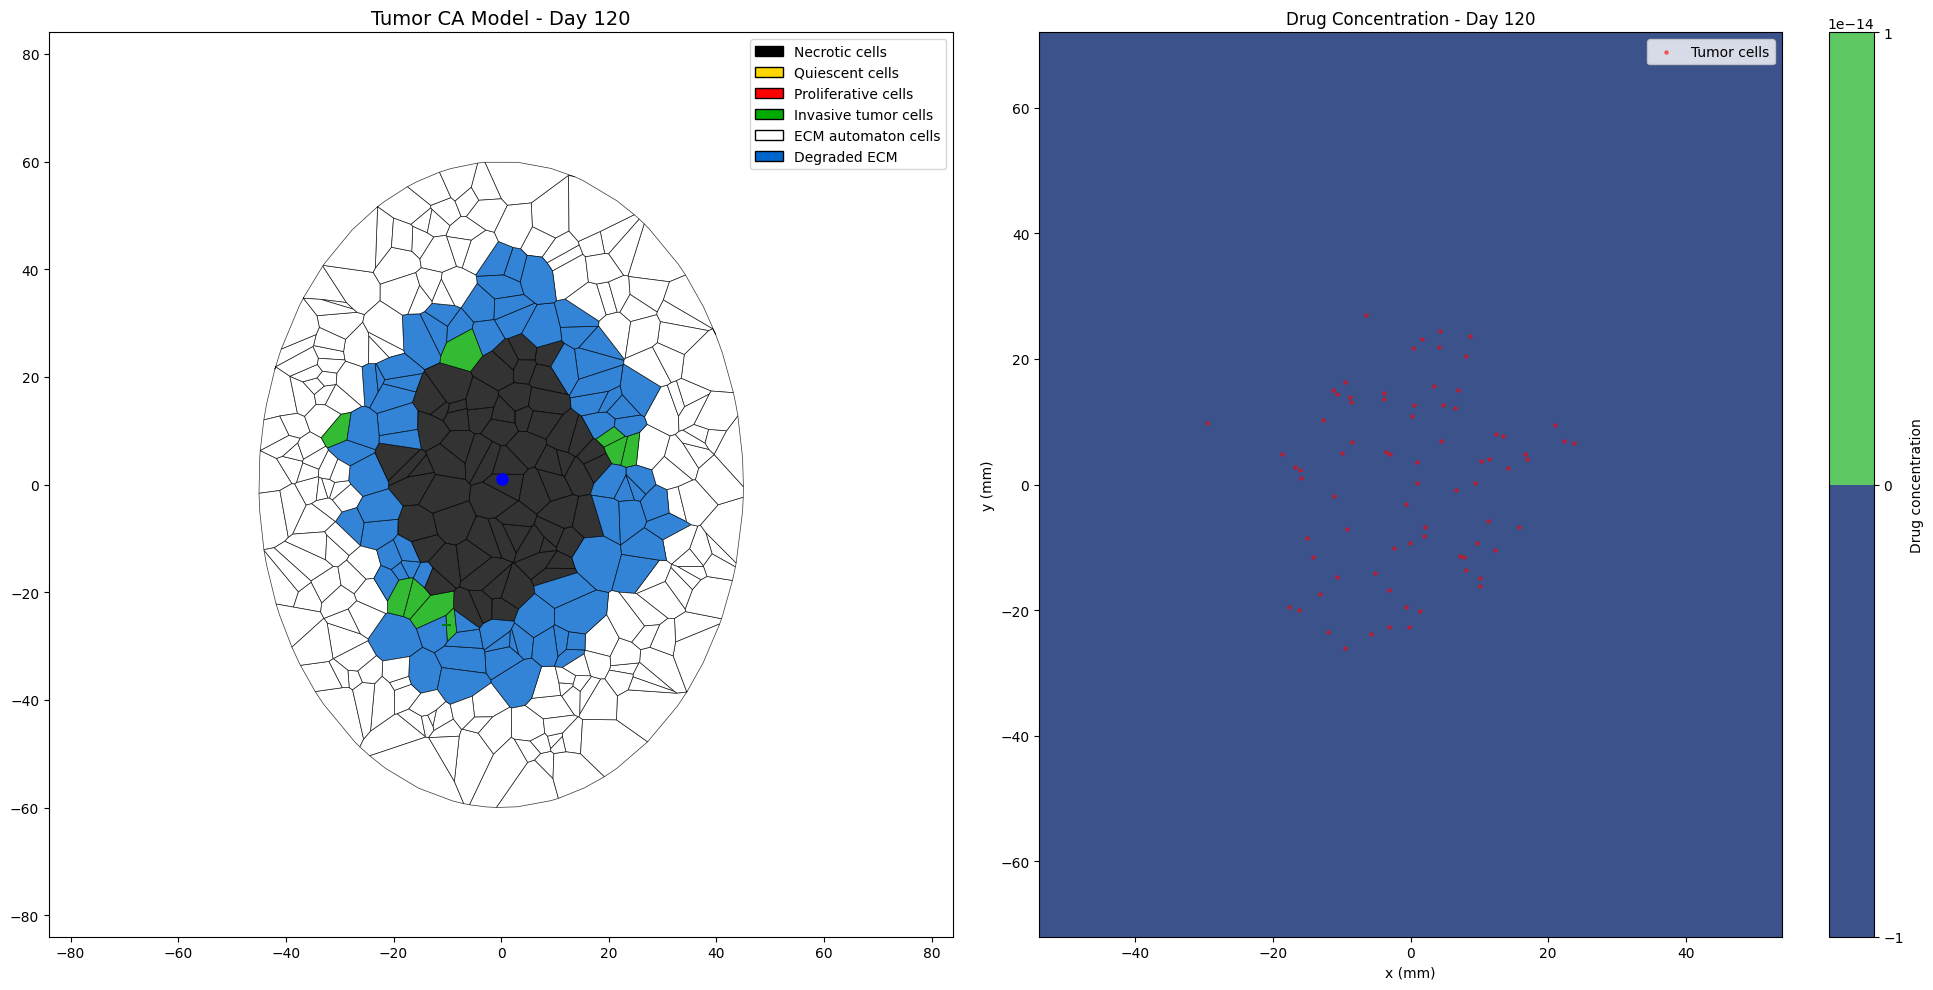

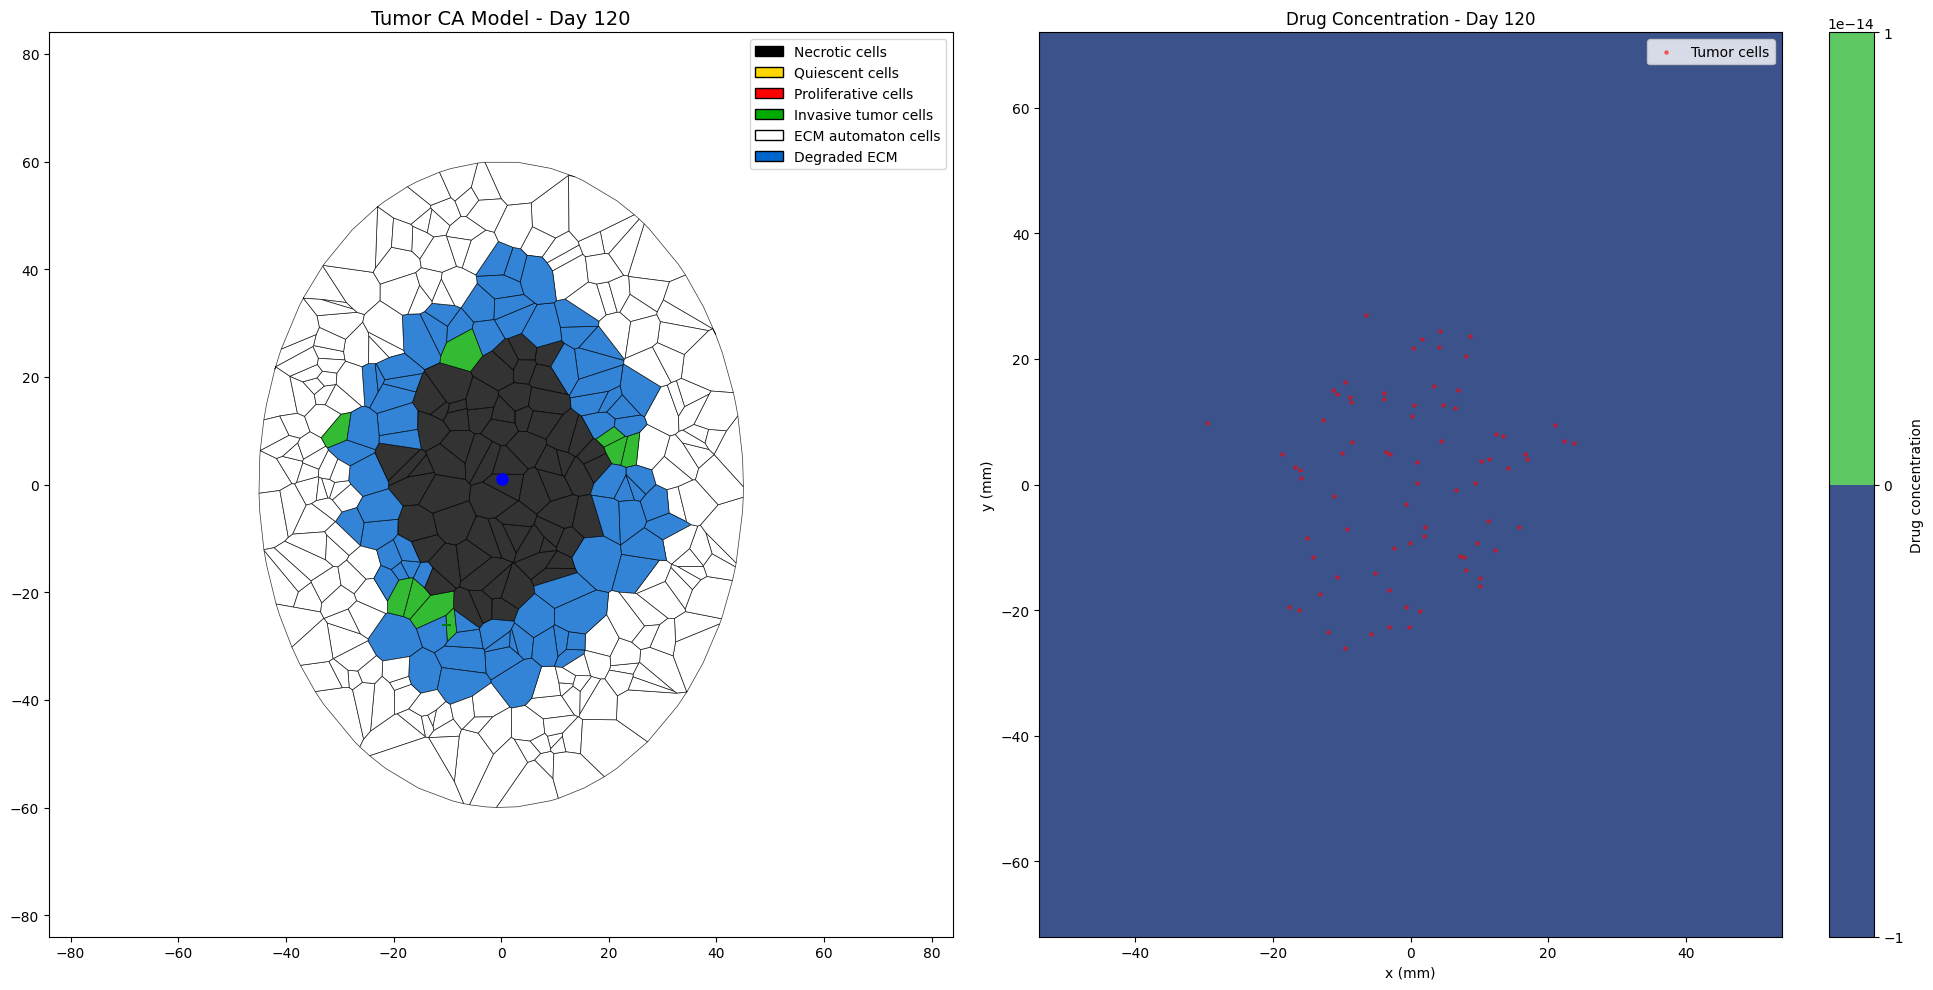

In [33]:
# Initialize with your Voronoi tumor model
hybrid_model = HybridTumorModel(voronoi_model, grid_size=50, days=120)

# Run the simulation
hybrid_model.simulate()

# Plot final state
hybrid_model.plot_state()

Simulating free growth...
Completed day 30/120
Completed day 60/120
Completed day 90/120
Completed day 120/120
Simulating P0_g=0.6...
Completed day 30/120
Completed day 60/120
Completed day 90/120
Completed day 120/120
Simulating P0_g=0.3...
Completed day 30/120
Completed day 60/120
Completed day 90/120
Completed day 120/120


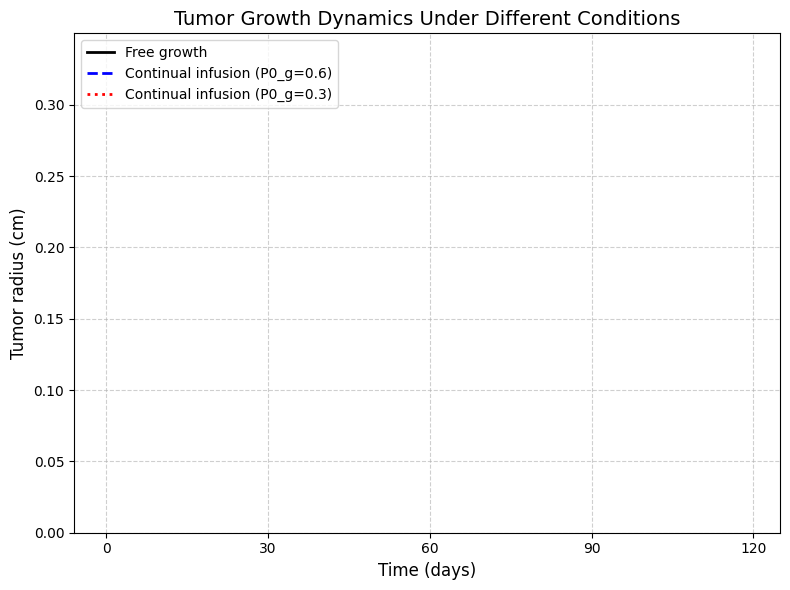

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class HybridTumorModelWithDosing(HybridTumorModel):
    def __init__(self, voronoi_model, P0_g=1.0, grid_size=50, days=120):
        """
        Initialize the model with constant dosing conditions
        
        Parameters:
        voronoi_model: Voronoi tumor model
        P0_g: Cell division reduction factor (1.0=free growth, 0.6, 0.3)
        grid_size: Resolution for finite difference grid
        days: Simulation duration (120 days)
        """
        super().__init__(voronoi_model, grid_size, days)
        self.P0_g = P0_g  # Cell division reduction factor
        self.boundary_concentration = 1.0  # Constant boundary concentration
        self.tumor_radius_history = []  # Store radius in cm
        
    def apply_boundary_conditions(self):
        """Apply constant drug concentration at boundaries"""
        if self.P0_g < 1.0:  # Only apply dosing for drug cases
            self.phi[0,:] = self.boundary_concentration    # Left boundary
            self.phi[-1,:] = self.boundary_concentration   # Right boundary
            self.phi[:,0] = self.boundary_concentration    # Bottom boundary
            self.phi[:,-1] = self.boundary_concentration   # Top boundary
    
    def calculate_tumor_radius(self):
        """Calculate tumor radius in cm using convex hull"""
        tumor_points = []
        for i in range(len(self.ca_model.points)):
            if self.ca_model.cell_types[i] not in [self.ca_model.voronoi.ECM, 
                                                 self.ca_model.voronoi.DEGRADED_ECM]:
                tumor_points.append(self.ca_model.points[i])
        
        if len(tumor_points) < 3:
            return 0.0
        
        hull = ConvexHull(tumor_points)
        radius_mm = np.sqrt(hull.volume / np.pi)  # Equivalent radius in mm
        return radius_mm / 10  # Convert to cm
    
    def calculate_Pdiv(self, cell_idx):
        """Modified division probability with constant P0_g"""
        r = np.linalg.norm(self.ca_model.points[cell_idx] - self.ca_model.centroid)
        Lt = self.ca_model.calculate_Lt(cell_idx)
        Lmax = self.ca_model.calculate_Lmax(cell_idx)
        
        if Lmax == 0:
            return 0
            
        # Constant drug effect (spatially independent)
        Pg_phi = self.P0_g
        
        # Local ECM density
        neighbors = self.ca_model.get_neighbor_indices(cell_idx)
        if len(neighbors) == 0:
            r_ECM = 0
        else:
            r_ECM = np.mean([self.ca_model.ecm_density[j] for j in neighbors 
                            if self.ca_model.cell_types[j] in [self.ca_model.voronoi.ECM, 
                                                             self.ca_model.voronoi.DEGRADED_ECM]])
        
        # Division probability formula
        Pdiv = self.ca_model.p0 * Pg_phi * ((1 - r/Lmax) + (1 - r_ECM)) / 2
        
        return np.clip(Pdiv, 0, 1)
    
    def simulate_day(self):
        """Modified simulation day with radius tracking"""
        super().simulate_day()
        self.tumor_radius_history.append(self.calculate_tumor_radius())

def create_figure_4a(voronoi_model, days=120):
    """Create Figure 4A comparing growth under different conditions"""
    plt.figure(figsize=(8, 6))
    
    # Simulate free growth (P0_g = 1.0)
    print("Simulating free growth...")
    model_free = HybridTumorModelWithDosing(voronoi_model, P0_g=1.0, days=days)
    model_free.simulate()
    plt.plot(range(days), model_free.tumor_radius_history, 'k-', linewidth=2, label='Free growth')
    
    # Simulate continual infusion P0_g = 0.6
    print("Simulating P0_g=0.6...")
    model_p6 = HybridTumorModelWithDosing(voronoi_model, P0_g=0.6, days=days)
    model_p6.simulate()
    plt.plot(range(days), model_p6.tumor_radius_history, 'b--', linewidth=2, 
             label='Continual infusion (P0_g=0.6)')
    
    # Simulate continual infusion P0_g = 0.3
    print("Simulating P0_g=0.3...")
    model_p3 = HybridTumorModelWithDosing(voronoi_model, P0_g=0.3, days=days)
    model_p3.simulate()
    plt.plot(range(days), model_p3.tumor_radius_history, 'r:', linewidth=2,
             label='Continual infusion (P0_g=0.3)')
    
    # Format the plot to match the reference figure
    plt.xlabel('Time (days)', fontsize=12)
    plt.ylabel('Tumor radius (cm)', fontsize=12)
    plt.title('Tumor Growth Dynamics Under Different Conditions', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(np.arange(0, days+1, 30))
    plt.yticks(np.arange(0, 0.35, 0.05))
    plt.ylim(0, 0.35)
    
    plt.tight_layout()
    plt.savefig('figure_4a.png', dpi=300)
    plt.show()

# Example usage:
voronoi_model = VoronoiTumorModel(a=45, b=60, n_seeds=350)
create_figure_4a(voronoi_model)

In [28]:
# Test with 2 days and print all radii
test_model = HybridTumorModelWithDosing(voronoi_model,P0_g=0.6,days=120)
test_model.simulate()
#test_model.simulate_day()
#test_model.simulate_day()
print(test_model.tumor_radius_history)  # Should output [0.05, 0.051] (example)

Completed day 30/120
Completed day 60/120
Completed day 90/120
Completed day 120/120
[2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.3599518925891383, 2.359951892589